In [ ]:
# ============================================================
# Trial14: Trial13 + (A) Temporal Pooling + (B) Late-step Masking
#
# Motivation:
# - Your time permutation importance showed strong reliance on late timesteps.
# - Instead of using ONLY the last hidden state, we pool across time (mean_last_k / attention).
# - We add "late-step masking" (actually early-step masking) during training:
#     early timesteps are masked more often -> model learns to rely more on late dynamics.
#
# Keeps Trial9 evaluation pack: PH / α–λ / CRA / convergence + paper figures
#
# Folder:
#   ./Trial14/seed_<seed>/best_by_val_norm/...
#   ./Trial14/seed_<seed>/last_epoch/...
# ============================================================

import os
import random
from dataclasses import dataclass
from pathlib import Path
from typing import List, Tuple, Dict, Any, Optional

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


# ============================================================
# 0) Reproducibility
# ============================================================
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ============================================================
# 1) Config
# ============================================================
@dataclass
class Config:
    data_dir: str = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100"
    out_dir: str = r"./Trial14"

    # seeds to sweep
    seeds: Tuple[int, ...] = (9819123, 111, 222, 333, 444)

    # sliding window
    seq_len: int = 100
    stride: int = 5
    pred_horizon: int = 0

    # split by FILE
    train_ratio: float = 0.7
    val_ratio: float = 0.2
    test_ratio: float = 0.1

    # training
    batch_size: int = 512
    epochs: int = 300
    lr: float = 1e-3
    weight_decay: float = 0.0
    patience: int = 30
    grad_clip: float = 1.0

    # model
    hidden_size: int = 512
    num_layers: int = 2
    dropout: float = 0.2

    # data loading
    num_workers: int = 0

    # output controls
    save_figures: bool = True
    max_files_to_plot: Optional[int] = None  # None=all

    # ===========================
    # Trial9-style Evaluation settings
    # ===========================
    alpha: float = 0.20
    ph_consecutive_m: int = 5
    rep_method: str = "mean"
    lambdas: Tuple[float, ...] = (0.2, 0.4, 0.6, 0.8)
    lambda_to_plot: float = 0.6
    eps_rul: float = 1e-8

    # ===========================
    # Trial13: Feature engineering from min_vce ONLY
    # ===========================
    delta_steps: Tuple[int, ...] = (1, 5, 20, 50)
    ema_spans: Tuple[int, ...] = (10, 50)
    roll_std_window: int = 10
    add_window_stats: bool = True

    # ===========================
    # Trial14-A: Temporal Pooling
    # ===========================
    # pooling: "last" | "mean_last_k" | "attn"
    pooling: str = "mean_last_k"
    pool_last_k: int = 10  # used when pooling="mean_last_k"
    attn_dim: int = 128    # used when pooling="attn"

    # ===========================
    # Trial14-B: Late-step masking (early-step masking)
    # ===========================
    # Apply ONLY during training (train_ds).
    time_mask_enable: bool = True
    time_mask_pmax: float = 0.35  # max mask prob at earliest timestep
    time_mask_gamma: float = 2.0  # larger => even more early-heavy masking
    time_mask_value: float = 0.0  # masked feature value after scaling
    # Optional: mask the whole timestep (all features) vs mask each feature independently
    time_mask_mode: str = "timestep"  # "timestep" or "feature"


# ============================================================
# 2) Data utils
# ============================================================
def list_csv_files(data_dir: str) -> List[Path]:
    p = Path(data_dir)
    files = sorted([f for f in p.glob("*.csv") if f.is_file()])
    if len(files) == 0:
        raise FileNotFoundError(f"No CSV files found in: {data_dir}")
    return files


def read_one_csv(csv_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path, header=None)
    if df.shape[1] < 2:
        raise ValueError(f"{csv_path.name}: expected at least 2 columns, got {df.shape[1]}")
    vce = df.iloc[:, 0].astype(np.float32).to_numpy()
    rul = df.iloc[:, 1].astype(np.float32).to_numpy()

    if len(vce) != len(rul):
        raise ValueError(f"{csv_path.name}: length mismatch vce={len(vce)}, rul={len(rul)}")
    if len(vce) < 5:
        raise ValueError(f"{csv_path.name}: too short sequence length={len(vce)}")
    return vce, rul


def split_files(
    files: List[Path],
    train_ratio: float,
    val_ratio: float,
    test_ratio: float,
    seed: int
) -> Dict[str, List[Path]]:
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9

    rng = random.Random(seed)
    files_shuffled = files[:]
    rng.shuffle(files_shuffled)

    n = len(files_shuffled)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_files = files_shuffled[:n_train]
    val_files = files_shuffled[n_train:n_train + n_val]
    test_files = files_shuffled[n_train + n_val:]

    return {"train": train_files, "val": val_files, "test": test_files}


def delta_k(v: np.ndarray, k: int) -> np.ndarray:
    out = np.zeros_like(v, dtype=np.float32)
    if k <= 0:
        return out
    out[k:] = v[k:] - v[:-k]
    return out


def ema(v: np.ndarray, span: int) -> np.ndarray:
    if span <= 1:
        return v.astype(np.float32).copy()
    a = 2.0 / (float(span) + 1.0)
    out = np.zeros_like(v, dtype=np.float32)
    out[0] = v[0]
    for i in range(1, len(v)):
        out[i] = a * v[i] + (1.0 - a) * out[i - 1]
    return out


def rolling_std(v: np.ndarray, w: int) -> np.ndarray:
    w = int(w)
    out = np.zeros_like(v, dtype=np.float32)
    for i in range(len(v)):
        j0 = max(0, i - w + 1)
        out[i] = float(np.std(v[j0:i + 1], ddof=0))
    return out


def feature_names(cfg: Config) -> List[str]:
    names = ["min_vce"]
    for k in cfg.delta_steps:
        names.append(f"delta_{k}")
    for s in cfg.ema_spans:
        names.append(f"ema_{s}")
    if cfg.roll_std_window and cfg.roll_std_window > 1:
        names.append(f"rollstd_{cfg.roll_std_window}")
    if cfg.add_window_stats:
        names += ["win_mean", "win_std", "win_slope"]
    return names


def build_features_from_min_vce(vce: np.ndarray, cfg: Config) -> np.ndarray:
    feats = [vce.astype(np.float32)]

    for k in cfg.delta_steps:
        feats.append(delta_k(vce, int(k)))

    for s in cfg.ema_spans:
        feats.append(ema(vce, int(s)))

    if cfg.roll_std_window and cfg.roll_std_window > 1:
        feats.append(rolling_std(vce, int(cfg.roll_std_window)))

    X = np.stack(feats, axis=1).astype(np.float32)  # (T, F_base)
    return X


def _window_slope(seg: np.ndarray) -> float:
    L = len(seg)
    if L <= 1:
        return 0.0
    t = np.arange(L, dtype=np.float32)
    denom = float(np.var(t) + 1e-12)
    if denom <= 0:
        return 0.0
    # cov(t, seg)/var(t)
    return float(np.cov(t, seg, ddof=0)[0, 1] / denom)


def apply_late_step_masking(x: np.ndarray, cfg: Config, rng: np.random.RandomState) -> np.ndarray:
    """
    x: (L, F) float32 (already scaled)
    Early-heavy masking:
      p(t) = pmax * (1 - t/(L-1))^gamma
      t=0 => pmax, t=L-1 => ~0
    """
    if (not cfg.time_mask_enable) or cfg.time_mask_pmax <= 0:
        return x

    L, F = x.shape
    if L <= 1:
        return x

    t = np.arange(L, dtype=np.float32)
    frac = t / float(L - 1)
    p = float(cfg.time_mask_pmax) * np.power((1.0 - frac), float(cfg.time_mask_gamma))  # (L,)

    x2 = x.copy()

    if cfg.time_mask_mode == "timestep":
        m = rng.rand(L) < p  # (L,)
        if np.any(m):
            x2[m, :] = float(cfg.time_mask_value)
    elif cfg.time_mask_mode == "feature":
        # each feature independently
        M = rng.rand(L, F) < p.reshape(-1, 1)
        x2[M] = float(cfg.time_mask_value)
    else:
        # fallback
        m = rng.rand(L) < p
        if np.any(m):
            x2[m, :] = float(cfg.time_mask_value)

    return x2


# ============================================================
# 3) Dataset
# ============================================================
class WindowedRULDatasetNormMinVCE_Trial14(Dataset):
    """
    Returns:
      x: (seq_len, F)
      y_norm: (1,)
      name, start_idx, y_cycles, rul0
    """
    def __init__(
        self,
        file_list: List[Path],
        cfg: Config,
        scaler_x: StandardScaler = None,
        fit_scaler: bool = False,
        is_train: bool = False,
    ):
        self.file_list = file_list
        self.cfg = cfg
        self.seq_len = cfg.seq_len
        self.stride = cfg.stride
        self.pred_horizon = cfg.pred_horizon
        self.scaler_x = scaler_x if scaler_x is not None else StandardScaler()
        self.is_train = bool(is_train)

        # deterministic rng for masking (per dataset instance)
        self._rng = np.random.RandomState(1234 if self.is_train else 4321)

        # store: (name, Xbase(T,Fbase), vce(T,), rul(T,), rul0)
        self.series: List[Tuple[str, np.ndarray, np.ndarray, np.ndarray, float]] = []
        for fp in self.file_list:
            vce, rul = read_one_csv(fp)
            rul0 = float(rul[0])
            if rul0 <= 0:
                raise ValueError(f"{fp.name}: RUL0 must be > 0, got {rul0}")

            Xbase = build_features_from_min_vce(vce, cfg).astype(np.float32)
            self.series.append((fp.name, Xbase, vce.astype(np.float32), rul.astype(np.float32), rul0))

        # Fit scaler
        if fit_scaler:
            if not cfg.add_window_stats:
                all_x = np.concatenate([Xbase for _, Xbase, _, _, _ in self.series], axis=0)
                self.scaler_x.fit(all_x)
            else:
                rng = np.random.RandomState(0)
                rows = []
                max_windows_for_scaler = 5000
                for (_name, Xbase, vce_raw, _rul, _rul0) in self.series:
                    T = Xbase.shape[0]
                    last_start = T - (self.seq_len + self.pred_horizon)
                    if last_start < 0:
                        continue
                    starts = list(range(0, last_start + 1, self.stride))
                    if len(starts) == 0:
                        continue
                    if len(starts) > 200:
                        starts = rng.choice(starts, size=200, replace=False).tolist()
                    for s in starts:
                        xw = Xbase[s:s + self.seq_len, :]
                        seg = vce_raw[s:s + self.seq_len]
                        wmean = float(np.mean(seg))
                        wstd = float(np.std(seg, ddof=0))
                        slope = _window_slope(seg)
                        stats = np.array([wmean, wstd, slope], dtype=np.float32).reshape(1, 3)
                        stats_rep = np.repeat(stats, repeats=self.seq_len, axis=0)
                        xfull = np.concatenate([xw, stats_rep], axis=1)
                        rows.append(xfull)
                        if len(rows) >= max_windows_for_scaler:
                            break
                    if len(rows) >= max_windows_for_scaler:
                        break
                if len(rows) == 0:
                    raise ValueError("Scaler fitting failed: no windows sampled. Check seq_len/stride.")
                fit_mat = np.concatenate(rows, axis=0)
                self.scaler_x.fit(fit_mat)

        # window index
        self.index: List[Tuple[int, int]] = []
        for fi, (_name, Xbase, _vce, _rul, _rul0) in enumerate(self.series):
            T = Xbase.shape[0]
            last_start = T - (self.seq_len + self.pred_horizon)
            if last_start < 0:
                continue
            for s in range(0, last_start + 1, self.stride):
                self.index.append((fi, s))

        if len(self.index) == 0:
            raise ValueError("No windows were created. Check seq_len/pred_horizon vs file lengths.")

    def __len__(self) -> int:
        return len(self.index)

    def __getitem__(self, idx: int):
        fi, s = self.index[idx]
        name, Xbase, vce_raw, rul, rul0 = self.series[fi]

        x = Xbase[s:s + self.seq_len, :]  # (L,Fbase)

        if self.cfg.add_window_stats:
            seg = vce_raw[s:s + self.seq_len]
            wmean = float(np.mean(seg))
            wstd = float(np.std(seg, ddof=0))
            slope = _window_slope(seg)
            stats = np.array([wmean, wstd, slope], dtype=np.float32).reshape(1, 3)
            stats_rep = np.repeat(stats, repeats=self.seq_len, axis=0)
            x = np.concatenate([x, stats_rep], axis=1).astype(np.float32)  # (L,F)

        y_idx = s + self.seq_len - 1 + self.pred_horizon
        y_cycles = float(rul[y_idx])
        y_norm = np.array([y_cycles / rul0], dtype=np.float32)

        # scale first
        x = self.scaler_x.transform(x).astype(np.float32)

        # Trial14-B: apply masking ONLY for training dataset
        if self.is_train and self.cfg.time_mask_enable:
            x = apply_late_step_masking(x, self.cfg, self._rng).astype(np.float32)

        return (
            torch.from_numpy(x),
            torch.from_numpy(y_norm),
            name,
            torch.tensor(s, dtype=torch.long),
            torch.tensor(y_cycles, dtype=torch.float32),
            torch.tensor(rul0, dtype=torch.float32),
        )


# ============================================================
# 4) Model (Temporal pooling)
# ============================================================
class TemporalPool(nn.Module):
    def __init__(self, mode: str, hidden_size: int, last_k: int = 10, attn_dim: int = 128):
        super().__init__()
        self.mode = str(mode)
        self.last_k = int(last_k)
        self.attn_dim = int(attn_dim)

        if self.mode == "attn":
            self.proj = nn.Sequential(
                nn.Linear(hidden_size, self.attn_dim),
                nn.Tanh(),
                nn.Linear(self.attn_dim, 1),
            )

    def forward(self, h: torch.Tensor) -> torch.Tensor:
        """
        h: (B, L, H)
        returns pooled: (B, H)
        """
        if self.mode == "last":
            return h[:, -1, :]

        if self.mode == "mean_last_k":
            L = h.size(1)
            k = min(self.last_k, L)
            return torch.mean(h[:, -k:, :], dim=1)

        if self.mode == "attn":
            # scores: (B, L, 1) -> weights: (B, L, 1)
            scores = self.proj(h)
            w = torch.softmax(scores, dim=1)
            return torch.sum(w * h, dim=1)

        # fallback
        return h[:, -1, :]


class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float,
                 pooling: str, pool_last_k: int, attn_dim: int):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.pool = TemporalPool(pooling, hidden_size, last_k=pool_last_k, attn_dim=attn_dim)
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1),
        )

    def forward(self, x):
        h, _ = self.lstm(x)           # (B, L, H)
        z = self.pool(h)              # (B, H)
        return self.head(z)           # (B, 1) norm-scale


# ============================================================
# 5) Basic Eval + Save window-level predictions
# ============================================================
@torch.no_grad()
def evaluate_basic(model, loader, device) -> Dict[str, float]:
    model.eval()

    mae_norm_list, mse_norm_list = [], []
    mae_cyc_list, mse_cyc_list = [], []

    for x, y_norm, _name, _s, y_cycles, rul0 in loader:
        x = x.to(device)
        y_norm = y_norm.to(device)
        y_cycles = y_cycles.to(device).view(-1, 1)
        rul0 = rul0.to(device).view(-1, 1)

        pred_norm = model(x)

        err_norm = pred_norm - y_norm
        mae_norm_list.append(torch.mean(torch.abs(err_norm)).item())
        mse_norm_list.append(torch.mean(err_norm ** 2).item())

        pred_cycles = pred_norm * rul0
        err_cyc = pred_cycles - y_cycles
        mae_cyc_list.append(torch.mean(torch.abs(err_cyc)).item())
        mse_cyc_list.append(torch.mean(err_cyc ** 2).item())

    return {
        "mae_norm": float(np.mean(mae_norm_list)) if mae_norm_list else float("nan"),
        "rmse_norm": float(np.sqrt(np.mean(mse_norm_list))) if mse_norm_list else float("nan"),
        "mae_cycles": float(np.mean(mae_cyc_list)) if mae_cyc_list else float("nan"),
        "rmse_cycles": float(np.sqrt(np.mean(mse_cyc_list))) if mse_cyc_list else float("nan"),
    }


@torch.no_grad()
def save_predictions_windows_csv(model, loader, device, out_csv: str, seq_len: int) -> None:
    model.eval()
    rows: List[Dict[str, Any]] = []

    for x, y_norm, name, s, y_cycles, rul0 in loader:
        x = x.to(device)
        y_norm = y_norm.to(device)
        y_cycles = y_cycles.to(device).view(-1, 1)
        rul0 = rul0.to(device).view(-1, 1)

        pred_norm = model(x)
        pred_cycles = pred_norm * rul0

        pred_norm_np = pred_norm.cpu().numpy().reshape(-1)
        y_norm_np = y_norm.cpu().numpy().reshape(-1)
        pred_cyc_np = pred_cycles.cpu().numpy().reshape(-1)
        y_cyc_np = y_cycles.cpu().numpy().reshape(-1)

        rul0_np = rul0.cpu().numpy().reshape(-1)
        s_np = s.cpu().numpy().reshape(-1)
        name_list = list(name)

        for i in range(len(pred_norm_np)):
            rows.append({
                "file": name_list[i],
                "start_idx": int(s_np[i]),
                "cycle": int(s_np[i] + (seq_len - 1)),
                "rul0": float(rul0_np[i]),
                "RUL_true": float(y_cyc_np[i]),
                "RUL_pred": float(pred_cyc_np[i]),
                "RUL_true_norm": float(y_norm_np[i]),
                "RUL_pred_norm": float(pred_norm_np[i]),
            })

    pd.DataFrame(rows).to_csv(out_csv, index=False)


# ============================================================
# 6) Window -> Cycle sequence (mean representative)
# ============================================================
def windows_to_cycle_sequence_mean(windows_csv: str) -> pd.DataFrame:
    dfw = pd.read_csv(windows_csv)
    if dfw.empty:
        raise ValueError(f"Empty windows csv: {windows_csv}")

    g = dfw.groupby(["file", "cycle"], as_index=False).agg(
        rul0=("rul0", "first"),
        RUL_true=("RUL_true", "mean"),
        RUL_pred=("RUL_pred", "mean"),
        n_windows=("RUL_pred", "count"),
    )
    return g


# ============================================================
# 7) Prognostics metrics (same as Trial9)
# ============================================================
def compute_metrics_for_one_file(
    df_seq_one_file: pd.DataFrame,
    seq_len: int,
    alpha: float,
    ph_consecutive_m: int,
    lambdas: Tuple[float, ...],
    eps_rul: float,
) -> Tuple[pd.DataFrame, Dict[str, Any]]:

    df = df_seq_one_file.sort_values("cycle").reset_index(drop=True).copy()

    t_s = seq_len - 1
    last_cycle = int(df["cycle"].max())
    EOL_true = last_cycle + 1
    t_e = EOL_true - 1

    df_eval = df[(df["cycle"] >= t_s) & (df["cycle"] <= t_e)].copy()
    df_eval.reset_index(drop=True, inplace=True)

    if df_eval.empty:
        summary = {
            "t_s": t_s, "t_e": t_e, "EOL_true": EOL_true,
            "PH": np.nan, "t_PH_start": np.nan,
            "CRA": np.nan, "Convergence_cycles": np.nan,
        }
        for lam in lambdas:
            summary[f"t_lambda_{lam:.2f}"] = np.nan
            summary[f"alpha_lambda_ok_{lam:.2f}"] = np.nan
        return df_eval, summary

    denom = np.maximum(np.abs(df_eval["RUL_true"].values), eps_rul)
    rel_err = np.abs(df_eval["RUL_true"].values - df_eval["RUL_pred"].values) / denom
    RA = 1.0 - rel_err

    df_eval["rel_err"] = rel_err
    df_eval["RA"] = RA
    df_eval["in_alpha"] = df_eval["rel_err"] <= alpha

    CRA = float(np.mean(df_eval["RA"].values))

    flags = df_eval["in_alpha"].values.astype(np.int32)
    t_PH_start = np.nan
    if len(flags) >= ph_consecutive_m:
        run = 0
        for i, ok in enumerate(flags):
            if ok:
                run += 1
                if run >= ph_consecutive_m:
                    start_i = i - ph_consecutive_m + 1
                    t_PH_start = int(df_eval.loc[start_i, "cycle"])
                    break
            else:
                run = 0

    if np.isfinite(t_PH_start):
        PH = float(EOL_true - t_PH_start)
        Convergence_cycles = float(t_PH_start - t_s)
    else:
        PH = np.nan
        Convergence_cycles = np.nan

    rul0 = float(df_eval["rul0"].iloc[0])
    lam_results = {}
    for lam in lambdas:
        target_rul = (1.0 - float(lam)) * rul0
        idx = int(np.argmin(np.abs(df_eval["RUL_true"].values - target_rul)))
        t_lam = int(df_eval.loc[idx, "cycle"])
        ok = bool(df_eval.loc[idx, "rel_err"] <= alpha)

        lam_results[f"t_lambda_{lam:.2f}"] = t_lam
        lam_results[f"alpha_lambda_ok_{lam:.2f}"] = int(ok)

    summary = {
        "t_s": int(t_s),
        "t_e": int(t_e),
        "EOL_true": int(EOL_true),
        "alpha": float(alpha),
        "ph_consecutive_m": int(ph_consecutive_m),
        "CRA": CRA,
        "t_PH_start": t_PH_start if np.isfinite(t_PH_start) else np.nan,
        "PH": PH,
        "Convergence_cycles": Convergence_cycles,
        **lam_results
    }
    return df_eval, summary


def compute_metrics_from_windows_csv(
    windows_csv: str,
    seq_len: int,
    alpha: float,
    ph_consecutive_m: int,
    lambdas: Tuple[float, ...],
    eps_rul: float,
    out_dir: str,
    split_name: str,
) -> Tuple[str, str]:

    os.makedirs(out_dir, exist_ok=True)

    df_seq = windows_to_cycle_sequence_mean(windows_csv)
    seq_path = os.path.join(out_dir, f"{split_name}_cycle_sequence_mean.csv")
    df_seq.to_csv(seq_path, index=False)

    rows = []
    for f in df_seq["file"].unique():
        sub = df_seq[df_seq["file"] == f].copy()
        _df_eval, summary = compute_metrics_for_one_file(
            df_seq_one_file=sub,
            seq_len=seq_len,
            alpha=alpha,
            ph_consecutive_m=ph_consecutive_m,
            lambdas=lambdas,
            eps_rul=eps_rul,
        )
        summary["file"] = f
        rows.append(summary)

    dfm = pd.DataFrame(rows)
    metrics_path = os.path.join(out_dir, f"{split_name}_prognostics_metrics_per_file.csv")
    dfm.to_csv(metrics_path, index=False)

    return seq_path, metrics_path


# ============================================================
# 8) Plotters (same as Trial13)
# ============================================================
def _safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")


def plot_alpha_ph(
    df_eval: pd.DataFrame,
    file_name: str,
    title: str,
    alpha: float,
    PH_start: Optional[float],
    out_path: str,
    dpi: int = 200,
) -> None:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.figure()

    x = df_eval["cycle"].values
    y_true = df_eval["RUL_true"].values
    y_pred = df_eval["RUL_pred"].values

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.plot(x, y_true, color="k", label="True (cycles)")
    plt.plot(x, y_pred, color="r", label="Prediction (cycles)")
    plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} alpha accuracy zone")
    plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} alpha accuracy zone")

    if PH_start is not None and np.isfinite(PH_start):
        plt.axvline(int(PH_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title}\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()


def plot_alpha_lambda(
    df_eval: pd.DataFrame,
    file_name: str,
    title: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    dpi: int = 200,
) -> None:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].values
    y_true = df_eval["RUL_true"].values
    y_pred = df_eval["RUL_pred"].values

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.figure()
    plt.plot(x, y_true, color="k", label="True (cycles)")
    plt.plot(x, y_pred, color="r", label="Prediction (cycles)")

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, linestyle=":", color="g", label=f"t_λ (λ={lambda_to_plot:.2f})")
        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], color="b", linestyle="--", label=f"+{alpha:.2f} alpha–lambda zone")
            plt.plot(x[mask], lower[mask], color="b", linestyle="--", label=f"-{alpha:.2f} alpha–lambda zone")
        else:
            plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} α zone")
    else:
        plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title}\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()


def make_paper_figures_for_split(
    cycle_seq_csv: str,
    metrics_per_file_csv: str,
    out_fig_dir: str,
    title_prefix: str,
    alpha: float,
    lambda_to_plot: float,
    max_files: Optional[int] = None,
    dpi: int = 200,
) -> None:
    df_seq = pd.read_csv(cycle_seq_csv)
    dfm = pd.read_csv(metrics_per_file_csv)

    files = df_seq["file"].unique().tolist()
    if max_files is not None:
        files = files[:max_files]

    os.makedirs(out_fig_dir, exist_ok=True)

    lam_key = f"t_lambda_{lambda_to_plot:.2f}"

    for f in files:
        sub = df_seq[df_seq["file"] == f].sort_values("cycle").copy()
        mrow = dfm[dfm["file"] == f]
        if mrow.empty:
            continue
        mrow = mrow.iloc[0].to_dict()

        t_s = int(mrow["t_s"])
        t_e = int(mrow["t_e"])
        PH_start = mrow.get("t_PH_start", np.nan)

        df_eval = sub[(sub["cycle"] >= t_s) & (sub["cycle"] <= t_e)].copy()
        if df_eval.empty:
            continue

        t_lambda = None
        if lam_key in mrow and np.isfinite(mrow[lam_key]):
            t_lambda = int(mrow[lam_key])

        safe = _safe_name(f)

        out1 = os.path.join(out_fig_dir, f"FIG1_alpha_PH__{safe}.png")
        plot_alpha_ph(
            df_eval=df_eval,
            file_name=f,
            title=f"{title_prefix} | α+PH",
            alpha=alpha,
            PH_start=PH_start if np.isfinite(PH_start) else None,
            out_path=out1,
            dpi=dpi,
        )

        out2 = os.path.join(out_fig_dir, f"FIG2_alpha_lambda__lam{lambda_to_plot:.2f}__{safe}.png")
        plot_alpha_lambda(
            df_eval=df_eval,
            file_name=f,
            title=f"{title_prefix} | α–λ (λ={lambda_to_plot:.2f})",
            alpha=alpha,
            lambda_to_plot=lambda_to_plot,
            t_lambda=t_lambda,
            out_path=out2,
            dpi=dpi,
        )


# ============================================================
# 9) One seed run
# ============================================================
def run_one_seed(cfg: Config, seed: int) -> Dict[str, Any]:
    set_seed(seed)

    seed_dir = os.path.join(cfg.out_dir, f"seed_{seed}")
    os.makedirs(seed_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n==============================")
    print(f"[SEED {seed}] device={device}")
    print(f"[SEED {seed}] out={seed_dir}")
    print(f"==============================")

    # split
    files = list_csv_files(cfg.data_dir)
    splits = split_files(files, cfg.train_ratio, cfg.val_ratio, cfg.test_ratio, seed)

    # save split lists
    for k in ["train", "val", "test"]:
        pd.Series([p.name for p in splits[k]]).to_csv(
            os.path.join(seed_dir, f"{k}_files.csv"), index=False, header=False
        )

    # datasets (fit scaler on train only)
    scaler_x = StandardScaler()
    train_ds = WindowedRULDatasetNormMinVCE_Trial14(
        splits["train"], cfg, scaler_x=scaler_x, fit_scaler=True, is_train=True
    )
    val_ds = WindowedRULDatasetNormMinVCE_Trial14(
        splits["val"], cfg, scaler_x=train_ds.scaler_x, fit_scaler=False, is_train=False
    )
    test_ds = WindowedRULDatasetNormMinVCE_Trial14(
        splits["test"], cfg, scaler_x=train_ds.scaler_x, fit_scaler=False, is_train=False
    )

    feat_list = feature_names(cfg)
    pd.DataFrame({
        "feature": feat_list,
        "mean": train_ds.scaler_x.mean_.ravel(),
        "std": np.sqrt(train_ds.scaler_x.var_).ravel(),
    }).to_csv(os.path.join(seed_dir, "scaler_x_mean_std.csv"), index=False)

    # loaders
    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
    val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

    train_eval = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
    val_eval = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
    test_eval = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

    # model
    input_size = len(feat_list)
    model = LSTMRegressor(
        input_size=input_size,
        hidden_size=cfg.hidden_size,
        num_layers=cfg.num_layers,
        dropout=cfg.dropout,
        pooling=cfg.pooling,
        pool_last_k=cfg.pool_last_k,
        attn_dim=cfg.attn_dim,
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    best_by_val_norm = float("inf")
    best_path = os.path.join(seed_dir, "best_by_val_norm.pt")
    last_path = os.path.join(seed_dir, "last_epoch.pt")

    history: List[Dict[str, Any]] = []
    bad_epochs = 0

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        losses = []

        for x, y_norm, *_ in train_loader:
            x = x.to(device)
            y_norm = y_norm.to(device)

            optimizer.zero_grad()
            pred_norm = model(x)
            loss = criterion(pred_norm, y_norm)
            loss.backward()

            if cfg.grad_clip and cfg.grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)

            optimizer.step()
            losses.append(loss.item())

        train_mse_norm = float(np.mean(losses)) if losses else float("nan")
        val_metrics = evaluate_basic(model, val_loader, device)

        history.append({
            "epoch": epoch,
            "train_mse_norm": train_mse_norm,
            "val_rmse_norm": val_metrics["rmse_norm"],
            "val_mae_norm": val_metrics["mae_norm"],
            "val_rmse_cycles": val_metrics["rmse_cycles"],
            "val_mae_cycles": val_metrics["mae_cycles"],
        })

        if val_metrics["rmse_norm"] < best_by_val_norm:
            best_by_val_norm = val_metrics["rmse_norm"]
            bad_epochs = 0
            torch.save(model.state_dict(), best_path)
        else:
            bad_epochs += 1

        if epoch == 1 or epoch % 10 == 0:
            print(
                f"[SEED {seed}] [{epoch:03d}/{cfg.epochs}] "
                f"train_mse_norm={train_mse_norm:.6f} | "
                f"val_rmse_norm={val_metrics['rmse_norm']:.6f} | "
                f"val_mae_cycles={val_metrics['mae_cycles']:.3f} | "
                f"best_val_rmse_norm={best_by_val_norm:.6f}"
            )

        if bad_epochs >= cfg.patience:
            print(f"[SEED {seed}] Early stopping at epoch {epoch}.")
            break

    pd.DataFrame(history).to_csv(os.path.join(seed_dir, "history.csv"), index=False)
    torch.save(model.state_dict(), last_path)

    def export_ckpt(tag: str, ckpt_path: str) -> Dict[str, Any]:
        sub_dir = os.path.join(seed_dir, tag)
        os.makedirs(sub_dir, exist_ok=True)

        model.load_state_dict(torch.load(ckpt_path, map_location=device))
        model.eval()

        tr = evaluate_basic(model, train_eval, device)
        va = evaluate_basic(model, val_eval, device)
        te = evaluate_basic(model, test_eval, device)

        for split_name, loader in [("train", train_eval), ("val", val_eval), ("test", test_eval)]:
            win_csv = os.path.join(sub_dir, f"{split_name}_predictions_windows.csv")
            save_predictions_windows_csv(model, loader, device, win_csv, seq_len=cfg.seq_len)

            seq_csv, metrics_csv = compute_metrics_from_windows_csv(
                windows_csv=win_csv,
                seq_len=cfg.seq_len,
                alpha=cfg.alpha,
                ph_consecutive_m=cfg.ph_consecutive_m,
                lambdas=cfg.lambdas,
                eps_rul=cfg.eps_rul,
                out_dir=sub_dir,
                split_name=split_name,
            )

            if cfg.save_figures:
                fig_dir = os.path.join(sub_dir, "paper_figures", split_name)
                make_paper_figures_for_split(
                    cycle_seq_csv=seq_csv,
                    metrics_per_file_csv=metrics_csv,
                    out_fig_dir=fig_dir,
                    title_prefix=f"SEED {seed} | {tag.upper()} | {split_name}",
                    alpha=cfg.alpha,
                    lambda_to_plot=cfg.lambda_to_plot,
                    max_files=cfg.max_files_to_plot,
                )

        ms = {
            "seed": seed,
            "checkpoint": tag,
            "train_rmse_cycles": tr["rmse_cycles"],
            "train_mae_cycles": tr["mae_cycles"],
            "train_rmse_norm": tr["rmse_norm"],
            "train_mae_norm": tr["mae_norm"],
            "val_rmse_cycles": va["rmse_cycles"],
            "val_mae_cycles": va["mae_cycles"],
            "val_rmse_norm": va["rmse_norm"],
            "val_mae_norm": va["mae_norm"],
            "test_rmse_cycles": te["rmse_cycles"],
            "test_mae_cycles": te["mae_cycles"],
            "test_rmse_norm": te["rmse_norm"],
            "test_mae_norm": te["mae_norm"],
            "stopped_epoch": history[-1]["epoch"] if len(history) else None,
            "best_val_rmse_norm": best_by_val_norm,
            "alpha": cfg.alpha,
            "ph_consecutive_m": cfg.ph_consecutive_m,
            "rep_method": cfg.rep_method,
            "lambdas": str(cfg.lambdas),
            "lambda_to_plot": cfg.lambda_to_plot,
            "feature_dim": input_size,
            "features": ",".join(feature_names(cfg)),
            # Trial14 extras
            "pooling": cfg.pooling,
            "pool_last_k": cfg.pool_last_k,
            "time_mask_enable": int(cfg.time_mask_enable),
            "time_mask_pmax": cfg.time_mask_pmax,
            "time_mask_gamma": cfg.time_mask_gamma,
            "time_mask_mode": cfg.time_mask_mode,
        }
        pd.DataFrame([ms]).to_csv(os.path.join(sub_dir, "metrics_summary.csv"), index=False)

        print(
            f"[SEED {seed}] {tag}: TEST mae_cycles={te['mae_cycles']:.3f} | "
            f"rmse_cycles={te['rmse_cycles']:.3f} | rmse_norm={te['rmse_norm']:.6f}"
        )
        return ms

    ms_best = export_ckpt("best_by_val_norm", best_path)
    ms_last = export_ckpt("last_epoch", last_path)

    return {"seed": seed, "seed_dir": seed_dir, "best": ms_best, "last": ms_last}


# ============================================================
# 10) Seed sweep + global comparison
# ============================================================
def summarize_across_seeds(cfg: Config, results: List[Dict[str, Any]]) -> None:
    rows = []
    for r in results:
        rows.append(r["best"])
        rows.append(r["last"])

    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(cfg.out_dir, "summary_across_seeds.csv"), index=False)

    def _isfinite(x: Any) -> bool:
        try:
            return bool(np.isfinite(float(x)))
        except Exception:
            return False

    def win_rate(metric: str) -> Dict[str, Any]:
        wins_last = 0
        wins_best = 0
        ties = 0
        diffs = []

        for r in results:
            b = r["best"][metric]
            l = r["last"][metric]
            if _isfinite(b) and _isfinite(l):
                diffs.append(float(l) - float(b))
                if float(l) < float(b):
                    wins_last += 1
                elif float(b) < float(l):
                    wins_best += 1
                else:
                    ties += 1

        return {
            "metric": metric,
            "wins_last": wins_last,
            "wins_best": wins_best,
            "ties": ties,
            "mean(last-best)": float(np.mean(diffs)) if diffs else float("nan"),
            "std(last-best)": float(np.std(diffs, ddof=0)) if diffs else float("nan"),
        }

    metrics = ["test_mae_cycles", "test_rmse_cycles", "test_mae_norm", "test_rmse_norm"]
    wr = [win_rate(m) for m in metrics]
    pd.DataFrame(wr).to_csv(os.path.join(cfg.out_dir, "win_rate_summary.csv"), index=False)

    lines = []
    lines.append("=== WIN-RATE SUMMARY (TEST; lower is better) ===")
    for row in wr:
        lines.append(
            f"- {row['metric']}: last wins={row['wins_last']}, best wins={row['wins_best']}, ties={row['ties']} | "
            f"mean(last-best)={row['mean(last-best)']:.6f}, std(last-best)={row['std(last-best)']:.6f}"
        )

    agg = df.groupby("checkpoint")[metrics].agg(["mean", "std"])
    lines.append("\n=== MEAN ± STD across seeds (TEST) ===")
    lines.append(str(agg))

    with open(os.path.join(cfg.out_dir, "win_rate_summary.txt"), "w", encoding="utf-8") as f:
        f.write("\n".join(lines))

    print("\n".join(lines))
    print("\nSaved:")
    print(" -", os.path.join(cfg.out_dir, "summary_across_seeds.csv"))
    print(" -", os.path.join(cfg.out_dir, "win_rate_summary.csv"))
    print(" -", os.path.join(cfg.out_dir, "win_rate_summary.txt"))


def run_trial14_seed_sweep(cfg: Config) -> None:
    os.makedirs(cfg.out_dir, exist_ok=True)

    results = []
    for seed in cfg.seeds:
        res = run_one_seed(cfg, seed)
        results.append(res)

    summarize_across_seeds(cfg, results)

    print("\nDONE. Check Trial14 folder:")
    print(" - per seed results: Trial14/seed_<seed>/...")
    print(" - figures (paper-style): seed_<seed>/<ckpt>/paper_figures/<split>/")
    print(" - cycle sequence mean CSV: <ckpt>/<split>_cycle_sequence_mean.csv")
    print(" - PH/α–λ metrics CSV: <ckpt>/<split>_prognostics_metrics_per_file.csv")


# ============================================================
# 11) Run
# ============================================================
if __name__ == "__main__":
    cfg = Config(
        data_dir=r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100",
        out_dir=r"./Trial14",

        seeds=(9819123, 111, 222, 333, 444),

        seq_len=100,
        stride=5,
        pred_horizon=0,

        train_ratio=0.7,
        val_ratio=0.2,
        test_ratio=0.1,

        batch_size=512,
        epochs=300,
        lr=1e-3,
        weight_decay=0.0,
        patience=30,
        grad_clip=1.0,

        hidden_size=512,
        num_layers=2,
        dropout=0.2,

        save_figures=True,
        max_files_to_plot=None,
        num_workers=0,

        alpha=0.20,
        ph_consecutive_m=5,
        rep_method="mean",
        lambdas=(0.2, 0.4, 0.6, 0.8),
        lambda_to_plot=0.6,

        # === Trial13 features (min_vce only) ===
        delta_steps=(1, 5, 20, 50),
        ema_spans=(10, 50),
        roll_std_window=10,
        add_window_stats=True,

        # === Trial14 changes ===
        pooling="mean_last_k",   # try: "mean_last_k" or "attn" or "last"
        pool_last_k=10,
        attn_dim=128,

        time_mask_enable=True,
        time_mask_pmax=0.35,
        time_mask_gamma=2.0,
        time_mask_value=0.0,
        time_mask_mode="timestep",
    )

    run_trial14_seed_sweep(cfg)



[SEED 9819123] device=cuda
[SEED 9819123] out=./Trial14\seed_9819123
[SEED 9819123] [001/300] train_mse_norm=0.022296 | val_rmse_norm=0.164454 | val_mae_cycles=2304.912 | best_val_rmse_norm=0.164454
[SEED 9819123] [010/300] train_mse_norm=0.016629 | val_rmse_norm=0.159979 | val_mae_cycles=2244.534 | best_val_rmse_norm=0.158172
[SEED 9819123] [020/300] train_mse_norm=0.016705 | val_rmse_norm=0.157696 | val_mae_cycles=2175.083 | best_val_rmse_norm=0.157696
[SEED 9819123] [030/300] train_mse_norm=0.016088 | val_rmse_norm=0.163209 | val_mae_cycles=2224.854 | best_val_rmse_norm=0.157696
[SEED 9819123] [040/300] train_mse_norm=0.012689 | val_rmse_norm=0.162197 | val_mae_cycles=2132.374 | best_val_rmse_norm=0.157378
[SEED 9819123] [050/300] train_mse_norm=0.002280 | val_rmse_norm=0.179738 | val_mae_cycles=2325.509 | best_val_rmse_norm=0.157378
[SEED 9819123] [060/300] train_mse_norm=0.000608 | val_rmse_norm=0.177955 | val_mae_cycles=2354.379 | best_val_rmse_norm=0.157378
[SEED 9819123] Early

C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_31012\1448923074.py:977: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 9819123] best_by_val_norm: TEST mae_cycles=1033.154 | rmse_cycles=1599.707 | rmse_norm=0.111484


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_31012\1448923074.py:977: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 9819123] last_epoch: TEST mae_cycles=1174.077 | rmse_cycles=1787.581 | rmse_norm=0.123437

[SEED 111] device=cuda
[SEED 111] out=./Trial14\seed_111
[SEED 111] [001/300] train_mse_norm=0.042643 | val_rmse_norm=0.134463 | val_mae_cycles=2576.141 | best_val_rmse_norm=0.134463
[SEED 111] [010/300] train_mse_norm=0.018061 | val_rmse_norm=0.146745 | val_mae_cycles=2855.620 | best_val_rmse_norm=0.134463
[SEED 111] [020/300] train_mse_norm=0.015565 | val_rmse_norm=0.144623 | val_mae_cycles=2824.658 | best_val_rmse_norm=0.132038
[SEED 111] [030/300] train_mse_norm=0.012059 | val_rmse_norm=0.159950 | val_mae_cycles=3085.744 | best_val_rmse_norm=0.132038
[SEED 111] [040/300] train_mse_norm=0.002024 | val_rmse_norm=0.163257 | val_mae_cycles=3282.342 | best_val_rmse_norm=0.132038
[SEED 111] Early stopping at epoch 41.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_31012\1448923074.py:977: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 111] best_by_val_norm: TEST mae_cycles=1809.596 | rmse_cycles=2851.311 | rmse_norm=0.151585


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_31012\1448923074.py:977: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 111] last_epoch: TEST mae_cycles=1585.218 | rmse_cycles=2529.418 | rmse_norm=0.144033

[SEED 222] device=cuda
[SEED 222] out=./Trial14\seed_222
[SEED 222] [001/300] train_mse_norm=0.022733 | val_rmse_norm=0.139011 | val_mae_cycles=1575.178 | best_val_rmse_norm=0.139011
[SEED 222] [010/300] train_mse_norm=0.018254 | val_rmse_norm=0.141020 | val_mae_cycles=1557.519 | best_val_rmse_norm=0.136616
[SEED 222] [020/300] train_mse_norm=0.017861 | val_rmse_norm=0.140039 | val_mae_cycles=1558.372 | best_val_rmse_norm=0.136616
[SEED 222] [030/300] train_mse_norm=0.009804 | val_rmse_norm=0.154699 | val_mae_cycles=1661.187 | best_val_rmse_norm=0.136616
[SEED 222] Early stopping at epoch 35.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_31012\1448923074.py:977: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 222] best_by_val_norm: TEST mae_cycles=2127.510 | rmse_cycles=3145.102 | rmse_norm=0.128156


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_31012\1448923074.py:977: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 222] last_epoch: TEST mae_cycles=2404.082 | rmse_cycles=3605.987 | rmse_norm=0.145702

[SEED 333] device=cuda
[SEED 333] out=./Trial14\seed_333
[SEED 333] [001/300] train_mse_norm=0.023093 | val_rmse_norm=0.123515 | val_mae_cycles=1496.794 | best_val_rmse_norm=0.123515
[SEED 333] [010/300] train_mse_norm=0.018690 | val_rmse_norm=0.125106 | val_mae_cycles=1483.803 | best_val_rmse_norm=0.123360
[SEED 333] [020/300] train_mse_norm=0.018895 | val_rmse_norm=0.126090 | val_mae_cycles=1485.783 | best_val_rmse_norm=0.121881
[SEED 333] [030/300] train_mse_norm=0.013758 | val_rmse_norm=0.131944 | val_mae_cycles=1493.846 | best_val_rmse_norm=0.121881
[SEED 333] [040/300] train_mse_norm=0.002140 | val_rmse_norm=0.143231 | val_mae_cycles=1695.928 | best_val_rmse_norm=0.121881
[SEED 333] Early stopping at epoch 41.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_31012\1448923074.py:977: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 333] best_by_val_norm: TEST mae_cycles=971.831 | rmse_cycles=1544.697 | rmse_norm=0.146952


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_31012\1448923074.py:977: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 333] last_epoch: TEST mae_cycles=962.831 | rmse_cycles=1647.031 | rmse_norm=0.157552

[SEED 444] device=cuda
[SEED 444] out=./Trial14\seed_444
[SEED 444] [001/300] train_mse_norm=0.035879 | val_rmse_norm=0.143768 | val_mae_cycles=2073.267 | best_val_rmse_norm=0.143768
[SEED 444] [010/300] train_mse_norm=0.017693 | val_rmse_norm=0.144096 | val_mae_cycles=2125.801 | best_val_rmse_norm=0.138893
[SEED 444] [020/300] train_mse_norm=0.017420 | val_rmse_norm=0.139118 | val_mae_cycles=2021.584 | best_val_rmse_norm=0.138893
[SEED 444] [030/300] train_mse_norm=0.017252 | val_rmse_norm=0.141903 | val_mae_cycles=2121.118 | best_val_rmse_norm=0.138715
[SEED 444] [040/300] train_mse_norm=0.011903 | val_rmse_norm=0.149142 | val_mae_cycles=2161.659 | best_val_rmse_norm=0.135164
[SEED 444] [050/300] train_mse_norm=0.001577 | val_rmse_norm=0.157321 | val_mae_cycles=2259.819 | best_val_rmse_norm=0.135164
[SEED 444] [060/300] train_mse_norm=0.000483 | val_rmse_norm=0.157743 | val_mae_cycles=2259.042

C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_31012\1448923074.py:977: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 444] best_by_val_norm: TEST mae_cycles=1321.993 | rmse_cycles=1926.283 | rmse_norm=0.132900


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_31012\1448923074.py:977: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 444] last_epoch: TEST mae_cycles=1421.075 | rmse_cycles=2184.222 | rmse_norm=0.145460
=== WIN-RATE SUMMARY (TEST; lower is better) ===
- test_mae_cycles: last wins=2, best wins=3, ties=0 | mean(last-best)=56.639665, std(last-best)=167.663100
- test_rmse_cycles: last wins=1, best wins=4, ties=0 | mean(last-best)=137.428133, std(last-best)=258.418174
- test_mae_norm: last wins=1, best wins=4, ties=0 | mean(last-best)=0.003877, std(last-best)=0.007330
- test_rmse_norm: last wins=1, best wins=4, ties=0 | mean(last-best)=0.009022, std(last-best)=0.008613

=== MEAN ± STD across seeds (TEST) ===
                 test_mae_cycles             test_rmse_cycles              \
                            mean         std             mean         std   
checkpoint                                                                  
best_by_val_norm     1452.816845  501.766993      2213.419915  738.447356   
last_epoch           1509.456509  553.440342      2350.848048  782.249073   

            

In [2]:
import os
import numpy as np
import pandas as pd

# ============================
# Trial14 paths
# ============================
TRIAL14_DIR = "./Trial14"
SUMMARY_CSV = os.path.join(TRIAL14_DIR, "summary_across_seeds.csv")

BEST_TAG = "best_by_val_norm"
LAST_TAG = "last_epoch"


def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in summary CSV: {missing}")


def pick_best_row(df: pd.DataFrame, metric_prefix: str = "val") -> pd.Series:
    """
    metric_prefix: "val" or "test"
    Sort rule (lower is better):
      1) <prefix>_rmse_cycles ascending
      2) <prefix>_mae_cycles  ascending
    """
    rmse_col = f"{metric_prefix}_rmse_cycles"
    mae_col = f"{metric_prefix}_mae_cycles"
    _require_cols(df, ["seed", "checkpoint", rmse_col, mae_col])

    df_sorted = df.sort_values(
        by=[rmse_col, mae_col],
        ascending=[True, True]
    ).reset_index(drop=True)

    return df_sorted.iloc[0]


def win_rate(df: pd.DataFrame, metric: str) -> dict:
    """
    Compare BEST_TAG vs LAST_TAG within each seed on the given metric (lower is better).
    Returns wins for last, wins for best, ties, and mean(last-best).
    """
    _require_cols(df, ["seed", "checkpoint", metric])

    wins_last = 0
    wins_best = 0
    ties = 0
    diffs = []

    for seed, g in df.groupby("seed"):
        ckpts = set(g["checkpoint"].astype(str).values)
        if not ({BEST_TAG, LAST_TAG} <= ckpts):
            continue

        b = float(g.loc[g["checkpoint"] == BEST_TAG, metric].iloc[0])
        l = float(g.loc[g["checkpoint"] == LAST_TAG, metric].iloc[0])

        if np.isfinite(b) and np.isfinite(l):
            diffs.append(l - b)  # negative => last better
            if l < b:
                wins_last += 1
            elif b < l:
                wins_best += 1
            else:
                ties += 1

    return {
        "metric": metric,
        "wins_last": wins_last,
        "wins_best": wins_best,
        "ties": ties,
        "mean(last-best)": float(np.mean(diffs)) if diffs else float("nan"),
        "std(last-best)": float(np.std(diffs, ddof=0)) if diffs else float("nan"),
    }


def main():
    if not os.path.exists(SUMMARY_CSV):
        raise FileNotFoundError(f"Not found: {SUMMARY_CSV}")

    df = pd.read_csv(SUMMARY_CSV)

    # -----------------------------
    # Trial14 summary columns sanity check
    # (matches ms dict in Trial14 run_one_seed.export_ckpt)
    # -----------------------------
    needed = [
        "seed", "checkpoint",
        "train_rmse_cycles", "train_mae_cycles", "train_rmse_norm", "train_mae_norm",
        "val_rmse_cycles", "val_mae_cycles", "val_rmse_norm", "val_mae_norm",
        "test_rmse_cycles", "test_mae_cycles", "test_rmse_norm", "test_mae_norm",
        "stopped_epoch", "best_val_rmse_norm",
        "alpha", "ph_consecutive_m", "rep_method", "lambdas", "lambda_to_plot",
        "feature_dim", "features",
        # Trial14 extras
        "pooling", "pool_last_k",
        "time_mask_enable", "time_mask_pmax", "time_mask_gamma", "time_mask_mode",
    ]
    _require_cols(df, needed)

    # -----------------------------
    # 1) VAL 기준 best (권장)
    # -----------------------------
    best_val = pick_best_row(df, metric_prefix="val")
    best_val_seed = int(best_val["seed"])
    best_val_ckpt = str(best_val["checkpoint"])

    # -----------------------------
    # 2) TEST 기준 best (보고용)
    # -----------------------------
    best_test = pick_best_row(df, metric_prefix="test")
    best_test_seed = int(best_test["seed"])
    best_test_ckpt = str(best_test["checkpoint"])

    # -----------------------------
    # 3) win-rate (seed별 last vs best 비교)
    # -----------------------------
    wr_val_rmse = win_rate(df, "val_rmse_cycles")
    wr_test_rmse = win_rate(df, "test_rmse_cycles")
    wr_val_rmse_norm = win_rate(df, "val_rmse_norm")
    wr_test_rmse_norm = win_rate(df, "test_rmse_norm")

    # -----------------------------
    # 4) 출력
    # -----------------------------
    print("\n================ BEST MODEL (Trial14) ================")
    print("[SELECTED BY VAL]  (recommended for model selection)")
    print(f"  Seed             : {best_val_seed}")
    print(f"  Checkpoint       : {best_val_ckpt}")
    print(f"  VAL  RMSE (cyc)   : {best_val['val_rmse_cycles']:.3f}")
    print(f"  VAL  MAE  (cyc)   : {best_val['val_mae_cycles']:.3f}")
    print(f"  VAL  RMSE (norm)  : {best_val['val_rmse_norm']:.6f}")
    print(f"  VAL  MAE  (norm)  : {best_val['val_mae_norm']:.6f}")
    print(f"  TEST RMSE (cyc)   : {best_val['test_rmse_cycles']:.3f}")
    print(f"  TEST MAE  (cyc)   : {best_val['test_mae_cycles']:.3f}")
    print(f"  TEST RMSE (norm)  : {best_val['test_rmse_norm']:.6f}")
    print(f"  TEST MAE  (norm)  : {best_val['test_mae_norm']:.6f}")

    print("\n  ---- Trial14 settings (from summary row) ----")
    print(f"  pooling          : {best_val['pooling']}")
    print(f"  pool_last_k      : {best_val['pool_last_k']}")
    print(f"  time_mask_enable : {best_val['time_mask_enable']}")
    print(f"  time_mask_pmax   : {best_val['time_mask_pmax']}")
    print(f"  time_mask_gamma  : {best_val['time_mask_gamma']}")
    print(f"  time_mask_mode   : {best_val['time_mask_mode']}")

    print("\n[SELECTED BY TEST] (for reporting only; not for tuning)")
    print(f"  Seed             : {best_test_seed}")
    print(f"  Checkpoint       : {best_test_ckpt}")
    print(f"  TEST RMSE (cyc)   : {best_test['test_rmse_cycles']:.3f}")
    print(f"  TEST MAE  (cyc)   : {best_test['test_mae_cycles']:.3f}")
    print(f"  TEST RMSE (norm)  : {best_test['test_rmse_norm']:.6f}")
    print(f"  TEST MAE  (norm)  : {best_test['test_mae_norm']:.6f}")
    print(f"  VAL  RMSE (cyc)   : {best_test['val_rmse_cycles']:.3f}")
    print(f"  VAL  MAE  (cyc)   : {best_test['val_mae_cycles']:.3f}")
    print(f"  VAL  RMSE (norm)  : {best_test['val_rmse_norm']:.6f}")
    print(f"  VAL  MAE  (norm)  : {best_test['val_mae_norm']:.6f}")

    print("\n---------------- WIN-RATE (last_epoch vs best_by_val_norm) ----------------")
    print(f"- {wr_val_rmse['metric']}: last wins={wr_val_rmse['wins_last']}, "
          f"best wins={wr_val_rmse['wins_best']}, ties={wr_val_rmse['ties']} | "
          f"mean(last-best)={wr_val_rmse['mean(last-best)']:.6f}")
    print(f"- {wr_test_rmse['metric']}: last wins={wr_test_rmse['wins_last']}, "
          f"best wins={wr_test_rmse['wins_best']}, ties={wr_test_rmse['ties']} | "
          f"mean(last-best)={wr_test_rmse['mean(last-best)']:.6f}")
    print(f"- {wr_val_rmse_norm['metric']}: last wins={wr_val_rmse_norm['wins_last']}, "
          f"best wins={wr_val_rmse_norm['wins_best']}, ties={wr_val_rmse_norm['ties']} | "
          f"mean(last-best)={wr_val_rmse_norm['mean(last-best)']:.6f}")
    print(f"- {wr_test_rmse_norm['metric']}: last wins={wr_test_rmse_norm['wins_last']}, "
          f"best wins={wr_test_rmse_norm['wins_best']}, ties={wr_test_rmse_norm['ties']} | "
          f"mean(last-best)={wr_test_rmse_norm['mean(last-best)']:.6f}")
    print("=====================================================\n")

    # -----------------------------
    # 5) 기록 저장 (VAL 기준 best)
    # -----------------------------
    out_txt = os.path.join(TRIAL14_DIR, "BEST_MODEL_BY_VAL.txt")
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write("BEST MODEL (Trial14) - Selected by VAL\n")
        f.write(f"seed={best_val_seed}\n")
        f.write(f"checkpoint={best_val_ckpt}\n")
        f.write(f"val_rmse_cycles={best_val['val_rmse_cycles']}\n")
        f.write(f"val_mae_cycles={best_val['val_mae_cycles']}\n")
        f.write(f"val_rmse_norm={best_val['val_rmse_norm']}\n")
        f.write(f"val_mae_norm={best_val['val_mae_norm']}\n")
        f.write(f"test_rmse_cycles={best_val['test_rmse_cycles']}\n")
        f.write(f"test_mae_cycles={best_val['test_mae_cycles']}\n")
        f.write(f"test_rmse_norm={best_val['test_rmse_norm']}\n")
        f.write(f"test_mae_norm={best_val['test_mae_norm']}\n")

        # Trial14 run settings / provenance
        for k in [
            "stopped_epoch", "best_val_rmse_norm",
            "alpha", "ph_consecutive_m", "rep_method", "lambdas", "lambda_to_plot",
            "feature_dim", "features",
            # Trial14 extras
            "pooling", "pool_last_k",
            "time_mask_enable", "time_mask_pmax", "time_mask_gamma", "time_mask_mode",
        ]:
            if k in best_val.index:
                f.write(f"{k}={best_val[k]}\n")

    print(f"Saved -> {out_txt}")


if __name__ == "__main__":
    main()



================ BEST MODEL (Trial14) ================
[SELECTED BY VAL]  (recommended for model selection)
  Seed             : 333
  Checkpoint       : best_by_val_norm
  VAL  RMSE (cyc)   : 2096.842
  VAL  MAE  (cyc)   : 1414.320
  VAL  RMSE (norm)  : 0.121881
  VAL  MAE  (norm)  : 0.094012
  TEST RMSE (cyc)   : 1544.697
  TEST MAE  (cyc)   : 971.831
  TEST RMSE (norm)  : 0.146952
  TEST MAE  (norm)  : 0.115696

  ---- Trial14 settings (from summary row) ----
  pooling          : mean_last_k
  pool_last_k      : 10
  time_mask_enable : 1
  time_mask_pmax   : 0.35
  time_mask_gamma  : 2.0
  time_mask_mode   : timestep

[SELECTED BY TEST] (for reporting only; not for tuning)
  Seed             : 333
  Checkpoint       : best_by_val_norm
  TEST RMSE (cyc)   : 1544.697
  TEST MAE  (cyc)   : 971.831
  TEST RMSE (norm)  : 0.146952
  TEST MAE  (norm)  : 0.115696
  VAL  RMSE (cyc)   : 2096.842
  VAL  MAE  (cyc)   : 1414.320
  VAL  RMSE (norm)  : 0.121881
  VAL  MAE  (norm)  : 0.094012

---

In [3]:
import os
import numpy as np
import pandas as pd

# ============================
# Trial14 paths
# ============================
TRIAL14_DIR = "./Trial14"
SUMMARY_CSV = os.path.join(TRIAL14_DIR, "summary_across_seeds.csv")

BEST_TAG = "best_by_val_norm"
LAST_TAG = "last_epoch"


def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in summary CSV: {missing}")


def pick_best_row_by_norm(df: pd.DataFrame, metric_prefix: str = "val") -> pd.Series:
    """
    metric_prefix: "val" or "test"
    Sort rule (lower is better):
      1) <prefix>_rmse_norm   ascending
      2) <prefix>_mae_norm    ascending
      3) <prefix>_rmse_cycles ascending  (tie-break)
      4) <prefix>_mae_cycles  ascending  (tie-break)
    """
    rmse_norm = f"{metric_prefix}_rmse_norm"
    mae_norm = f"{metric_prefix}_mae_norm"
    rmse_cyc = f"{metric_prefix}_rmse_cycles"
    mae_cyc = f"{metric_prefix}_mae_cycles"

    _require_cols(df, ["seed", "checkpoint", rmse_norm, mae_norm, rmse_cyc, mae_cyc])

    df_sorted = df.sort_values(
        by=[rmse_norm, mae_norm, rmse_cyc, mae_cyc],
        ascending=[True, True, True, True]
    ).reset_index(drop=True)

    return df_sorted.iloc[0]


def win_rate(df: pd.DataFrame, metric: str) -> dict:
    """
    Compare BEST_TAG vs LAST_TAG within each seed on the given metric (lower is better).
    Returns wins for last, wins for best, ties, and mean(last-best).
    """
    _require_cols(df, ["seed", "checkpoint", metric])

    wins_last = 0
    wins_best = 0
    ties = 0
    diffs = []

    for seed, g in df.groupby("seed"):
        ckpts = set(g["checkpoint"].astype(str).values)
        if not ({BEST_TAG, LAST_TAG} <= ckpts):
            continue

        b = float(g.loc[g["checkpoint"] == BEST_TAG, metric].iloc[0])
        l = float(g.loc[g["checkpoint"] == LAST_TAG, metric].iloc[0])

        if np.isfinite(b) and np.isfinite(l):
            diffs.append(l - b)  # negative => last better
            if l < b:
                wins_last += 1
            elif b < l:
                wins_best += 1
            else:
                ties += 1

    return {
        "metric": metric,
        "wins_last": wins_last,
        "wins_best": wins_best,
        "ties": ties,
        "mean(last-best)": float(np.mean(diffs)) if diffs else float("nan"),
        "std(last-best)": float(np.std(diffs, ddof=0)) if diffs else float("nan"),
    }


def main():
    if not os.path.exists(SUMMARY_CSV):
        raise FileNotFoundError(f"Not found: {SUMMARY_CSV}")

    df = pd.read_csv(SUMMARY_CSV)

    # -----------------------------
    # Trial14 summary columns sanity check
    # -----------------------------
    needed = [
        "seed", "checkpoint",
        "train_rmse_cycles", "train_mae_cycles", "train_rmse_norm", "train_mae_norm",
        "val_rmse_cycles", "val_mae_cycles", "val_rmse_norm", "val_mae_norm",
        "test_rmse_cycles", "test_mae_cycles", "test_rmse_norm", "test_mae_norm",
        "stopped_epoch", "best_val_rmse_norm",
        "alpha", "ph_consecutive_m", "rep_method", "lambdas", "lambda_to_plot",
        "feature_dim", "features",
        # Trial14 extras
        "pooling", "pool_last_k",
        "time_mask_enable", "time_mask_pmax", "time_mask_gamma", "time_mask_mode",
    ]
    _require_cols(df, needed)

    # -----------------------------
    # 1) VAL 기준 best (norm metric 기준) ✅
    # -----------------------------
    best_val = pick_best_row_by_norm(df, metric_prefix="val")
    best_val_seed = int(best_val["seed"])
    best_val_ckpt = str(best_val["checkpoint"])

    # -----------------------------
    # 2) TEST 기준 best (norm metric 기준) (보고용)
    # -----------------------------
    best_test = pick_best_row_by_norm(df, metric_prefix="test")
    best_test_seed = int(best_test["seed"])
    best_test_ckpt = str(best_test["checkpoint"])

    # -----------------------------
    # 3) win-rate (seed별 last vs best 비교)
    # -----------------------------
    wr_val_rmse = win_rate(df, "val_rmse_cycles")
    wr_test_rmse = win_rate(df, "test_rmse_cycles")
    wr_val_rmse_norm = win_rate(df, "val_rmse_norm")
    wr_test_rmse_norm = win_rate(df, "test_rmse_norm")

    # -----------------------------
    # 4) 출력
    # -----------------------------
    print("\n================ BEST MODEL (Trial14) ================")
    print("[SELECTED BY VAL (norm)]  (recommended for model selection)")
    print(f"  Seed             : {best_val_seed}")
    print(f"  Checkpoint       : {best_val_ckpt}")
    print(f"  VAL  RMSE (norm)  : {best_val['val_rmse_norm']:.6f}")
    print(f"  VAL  MAE  (norm)  : {best_val['val_mae_norm']:.6f}")
    print(f"  VAL  RMSE (cyc)   : {best_val['val_rmse_cycles']:.3f}")
    print(f"  VAL  MAE  (cyc)   : {best_val['val_mae_cycles']:.3f}")
    print(f"  TEST RMSE (norm)  : {best_val['test_rmse_norm']:.6f}")
    print(f"  TEST MAE  (norm)  : {best_val['test_mae_norm']:.6f}")
    print(f"  TEST RMSE (cyc)   : {best_val['test_rmse_cycles']:.3f}")
    print(f"  TEST MAE  (cyc)   : {best_val['test_mae_cycles']:.3f}")

    print("\n  ---- Trial14 settings (from summary row) ----")
    print(f"  pooling          : {best_val['pooling']}")
    print(f"  pool_last_k      : {best_val['pool_last_k']}")
    print(f"  time_mask_enable : {best_val['time_mask_enable']}")
    print(f"  time_mask_pmax   : {best_val['time_mask_pmax']}")
    print(f"  time_mask_gamma  : {best_val['time_mask_gamma']}")
    print(f"  time_mask_mode   : {best_val['time_mask_mode']}")

    print("\n[SELECTED BY TEST (norm)] (for reporting only; not for tuning)")
    print(f"  Seed             : {best_test_seed}")
    print(f"  Checkpoint       : {best_test_ckpt}")
    print(f"  TEST RMSE (norm)  : {best_test['test_rmse_norm']:.6f}")
    print(f"  TEST MAE  (norm)  : {best_test['test_mae_norm']:.6f}")
    print(f"  TEST RMSE (cyc)   : {best_test['test_rmse_cycles']:.3f}")
    print(f"  TEST MAE  (cyc)   : {best_test['test_mae_cycles']:.3f}")
    print(f"  VAL  RMSE (norm)  : {best_test['val_rmse_norm']:.6f}")
    print(f"  VAL  MAE  (norm)  : {best_test['val_mae_norm']:.6f}")
    print(f"  VAL  RMSE (cyc)   : {best_test['val_rmse_cycles']:.3f}")
    print(f"  VAL  MAE  (cyc)   : {best_test['val_mae_cycles']:.3f}")

    print("\n---------------- WIN-RATE (last_epoch vs best_by_val_norm) ----------------")
    print(f"- {wr_val_rmse_norm['metric']}: last wins={wr_val_rmse_norm['wins_last']}, "
          f"best wins={wr_val_rmse_norm['wins_best']}, ties={wr_val_rmse_norm['ties']} | "
          f"mean(last-best)={wr_val_rmse_norm['mean(last-best)']:.6f}")
    print(f"- {wr_test_rmse_norm['metric']}: last wins={wr_test_rmse_norm['wins_last']}, "
          f"best wins={wr_test_rmse_norm['wins_best']}, ties={wr_test_rmse_norm['ties']} | "
          f"mean(last-best)={wr_test_rmse_norm['mean(last-best)']:.6f}")
    print(f"- {wr_val_rmse['metric']}: last wins={wr_val_rmse['wins_last']}, "
          f"best wins={wr_val_rmse['wins_best']}, ties={wr_val_rmse['ties']} | "
          f"mean(last-best)={wr_val_rmse['mean(last-best)']:.6f}")
    print(f"- {wr_test_rmse['metric']}: last wins={wr_test_rmse['wins_last']}, "
          f"best wins={wr_test_rmse['wins_best']}, ties={wr_test_rmse['ties']} | "
          f"mean(last-best)={wr_test_rmse['mean(last-best)']:.6f}")
    print("=====================================================\n")

    # -----------------------------
    # 5) 기록 저장 (VAL(norm) 기준 best)
    # -----------------------------
    out_txt = os.path.join(TRIAL14_DIR, "BEST_MODEL_BY_VAL_NORM.txt")
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write("BEST MODEL (Trial14) - Selected by VAL (norm)\n")
        f.write(f"seed={best_val_seed}\n")
        f.write(f"checkpoint={best_val_ckpt}\n")
        f.write(f"val_rmse_norm={best_val['val_rmse_norm']}\n")
        f.write(f"val_mae_norm={best_val['val_mae_norm']}\n")
        f.write(f"val_rmse_cycles={best_val['val_rmse_cycles']}\n")
        f.write(f"val_mae_cycles={best_val['val_mae_cycles']}\n")
        f.write(f"test_rmse_norm={best_val['test_rmse_norm']}\n")
        f.write(f"test_mae_norm={best_val['test_mae_norm']}\n")
        f.write(f"test_rmse_cycles={best_val['test_rmse_cycles']}\n")
        f.write(f"test_mae_cycles={best_val['test_mae_cycles']}\n")

        for k in [
            "stopped_epoch", "best_val_rmse_norm",
            "alpha", "ph_consecutive_m", "rep_method", "lambdas", "lambda_to_plot",
            "feature_dim", "features",
            # Trial14 extras
            "pooling", "pool_last_k",
            "time_mask_enable", "time_mask_pmax", "time_mask_gamma", "time_mask_mode",
        ]:
            if k in best_val.index:
                f.write(f"{k}={best_val[k]}\n")

    print(f"Saved -> {out_txt}")


if __name__ == "__main__":
    main()



================ BEST MODEL (Trial14) ================
[SELECTED BY VAL (norm)]  (recommended for model selection)
  Seed             : 333
  Checkpoint       : best_by_val_norm
  VAL  RMSE (norm)  : 0.121881
  VAL  MAE  (norm)  : 0.094012
  VAL  RMSE (cyc)   : 2096.842
  VAL  MAE  (cyc)   : 1414.320
  TEST RMSE (norm)  : 0.146952
  TEST MAE  (norm)  : 0.115696
  TEST RMSE (cyc)   : 1544.697
  TEST MAE  (cyc)   : 971.831

  ---- Trial14 settings (from summary row) ----
  pooling          : mean_last_k
  pool_last_k      : 10
  time_mask_enable : 1
  time_mask_pmax   : 0.35
  time_mask_gamma  : 2.0
  time_mask_mode   : timestep

[SELECTED BY TEST (norm)] (for reporting only; not for tuning)
  Seed             : 9819123
  Checkpoint       : best_by_val_norm
  TEST RMSE (norm)  : 0.111484
  TEST MAE  (norm)  : 0.079971
  TEST RMSE (cyc)   : 1599.707
  TEST MAE  (cyc)   : 1033.154
  VAL  RMSE (norm)  : 0.157378
  VAL  MAE  (norm)  : 0.126985
  VAL  RMSE (cyc)   : 3006.334
  VAL  MAE  (cyc

In [5]:
import os
import pandas as pd
import numpy as np

# =========================
# USER CONFIG (Trial14)
# =========================
TRIAL14_DIR = r"./Trial14"          # ✅ Trial14 루트 폴더
SEED = 333                          # 선택된 seed
CKPT = "best_by_val_norm"           # "best_by_val_norm" or "last_epoch"
SPLITS = ["train", "val", "test"]   # 평가할 split
LAM_STRS = ["0.20", "0.40", "0.60", "0.80"]

# (선택) 후반 λ를 더 중요하게 보고 싶으면 가중치 사용
# 예: λ=0.2,0.4,0.6,0.8 가중치 = 1,1,2,3
LAMBDA_WEIGHTS = None  # 또는 {"0.20":1, "0.40":1, "0.60":2, "0.80":3}

# =========================
# Helpers
# =========================
def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")


def compute_alpha_lambda_rates(dfm: pd.DataFrame, lam_strs, weights=None) -> dict:
    """
    dfm: <split>_prognostics_metrics_per_file.csv  (per-file summary)
    Returns:
      - per-lambda success rate (mean of alpha_lambda_ok_{lam})
      - overall mean rate (simple mean or weighted mean)
    """
    rates = {}

    for ls in lam_strs:
        col = f"alpha_lambda_ok_{ls}"
        if col in dfm.columns:
            rates[f"rate_{ls}"] = float(dfm[col].mean())  # 0/1 평균 = 성공률
        else:
            rates[f"rate_{ls}"] = np.nan

    # overall score
    if weights is None:
        vals = [rates[f"rate_{ls}"] for ls in lam_strs if np.isfinite(rates[f"rate_{ls}"])]
        rates["rate_mean_all"] = float(np.mean(vals)) if vals else np.nan
    else:
        num = 0.0
        den = 0.0
        for ls in lam_strs:
            v = rates[f"rate_{ls}"]
            w = float(weights.get(ls, 0.0))
            if np.isfinite(v) and w > 0:
                num += w * v
                den += w
        rates["rate_weighted_all"] = (num / den) if den > 0 else np.nan

    return rates


def main():
    # Trial14 구조: ./Trial14/seed_<seed>/<ckpt>/
    seed_dir = os.path.join(TRIAL14_DIR, f"seed_{SEED}", CKPT)
    if not os.path.isdir(seed_dir):
        raise FileNotFoundError(f"Not found: {seed_dir}")

    out_dir = os.path.join(seed_dir, "alpha_lambda_eval")
    os.makedirs(out_dir, exist_ok=True)

    summary_rows = []
    per_file_rows = []  # (선택) 파일별 ok 값도 모아서 저장

    for split in SPLITS:
        mpath = os.path.join(seed_dir, f"{split}_prognostics_metrics_per_file.csv")
        if not os.path.exists(mpath):
            print(f"[SKIP] Missing: {mpath}")
            continue

        dfm = pd.read_csv(mpath)
        _require_cols(dfm, ["file"])  # 최소 file은 있어야 함

        # split 요약(성공률)
        rates = compute_alpha_lambda_rates(dfm, LAM_STRS, weights=LAMBDA_WEIGHTS)

        # Trial14 provenance(있으면 같이 저장)
        prov_cols = [
            "pooling", "pool_last_k",
            "time_mask_enable", "time_mask_pmax", "time_mask_gamma", "time_mask_mode",
        ]
        prov = {}
        for c in prov_cols:
            if c in dfm.columns:
                # per-file csv면 동일값일 가능성이 높지만, 우선 first로 저장
                prov[c] = dfm[c].iloc[0]

        row = {
            "seed": SEED,
            "checkpoint": CKPT,
            "split": split,
            "n_files": int(len(dfm)),
            **rates,
            **prov,
        }
        summary_rows.append(row)

        # (선택) 파일별 pass/fail + t_lambda 저장
        keep_cols = ["file"]
        for ls in LAM_STRS:
            c_ok = f"alpha_lambda_ok_{ls}"
            c_tl = f"t_lambda_{ls}"
            if c_ok in dfm.columns:
                keep_cols.append(c_ok)
            if c_tl in dfm.columns:
                keep_cols.append(c_tl)

        # provenance 컬럼이 dfm에 존재하면 같이 남김(있는 것만)
        for c in prov_cols:
            if c in dfm.columns and c not in keep_cols:
                keep_cols.append(c)

        sub = dfm[keep_cols].copy()
        sub.insert(0, "split", split)
        sub.insert(0, "checkpoint", CKPT)
        sub.insert(0, "seed", SEED)
        per_file_rows.append(sub)

        # 콘솔 출력
        msg_parts = []
        for ls in LAM_STRS:
            v = row.get(f"rate_{ls}", np.nan)
            if np.isfinite(v):
                msg_parts.append(f"λ={ls}:{v:.3f}")
        msg = ", ".join(msg_parts) if msg_parts else "no lambda columns found"
        tail = ""
        if "rate_weighted_all" in row and np.isfinite(row["rate_weighted_all"]):
            tail = f" | weighted_all={row['rate_weighted_all']:.3f}"
        elif "rate_mean_all" in row and np.isfinite(row["rate_mean_all"]):
            tail = f" | mean_all={row['rate_mean_all']:.3f}"
        print(f"[OK] {split}: {msg}{tail}")

    # 저장: split별 요약
    df_summary = pd.DataFrame(summary_rows)
    out_summary = os.path.join(out_dir, f"alpha_lambda_summary_seed{SEED}_{CKPT}.csv")
    df_summary.to_csv(out_summary, index=False)

    # 저장: 파일별 pass/fail (선택)
    out_pf = None
    if per_file_rows:
        df_pf = pd.concat(per_file_rows, axis=0, ignore_index=True)
        out_pf = os.path.join(out_dir, f"alpha_lambda_per_file_seed{SEED}_{CKPT}.csv")
        df_pf.to_csv(out_pf, index=False)

    print("\n==================== DONE ====================")
    print("Saved:")
    print(" -", out_summary)
    if out_pf:
        print(" -", out_pf)
    print("==============================================")


if __name__ == "__main__":
    main()


[OK] train: λ=0.20:0.700, λ=0.40:0.643, λ=0.60:0.557, λ=0.80:0.429 | mean_all=0.582
[OK] val: λ=0.20:0.650, λ=0.40:0.700, λ=0.60:0.650, λ=0.80:0.250 | mean_all=0.562
[OK] test: λ=0.20:0.600, λ=0.40:0.800, λ=0.60:0.800, λ=0.80:0.700 | mean_all=0.725

==================== DONE ====================
Saved:
 - ./Trial14\seed_333\best_by_val_norm\alpha_lambda_eval\alpha_lambda_summary_seed333_best_by_val_norm.csv
 - ./Trial14\seed_333\best_by_val_norm\alpha_lambda_eval\alpha_lambda_per_file_seed333_best_by_val_norm.csv


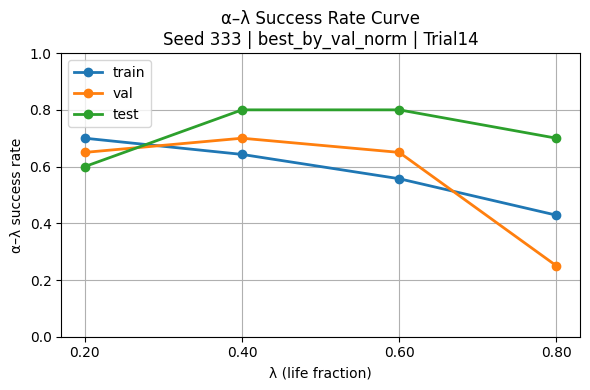

[SAVE] ./Trial14\seed_333\best_by_val_norm\alpha_lambda_eval\alpha_lambda_curve_seed333_best_by_val_norm.png


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# USER CONFIG (Trial14
# =========================
TRIAL14_DIR = r"./Trial14"
SEED = 333
CKPT = "best_by_val_norm"   # or "last_epoch"

LAM_STRS = ["0.20", "0.40", "0.60", "0.80"]
LAM = [float(x) for x in LAM_STRS]
SPLITS_ORDER = ["train", "val", "test"]

# =========================
# Paths
# =========================
AL_DIR = os.path.join(
    TRIAL14_DIR, f"seed_{SEED}", CKPT, "alpha_lambda_eval"
)
SUMMARY_CSV = os.path.join(
    AL_DIR, f"alpha_lambda_summary_seed{SEED}_{CKPT}.csv"
)
OUT_PNG = os.path.join(
    AL_DIR, f"alpha_lambda_curve_seed{SEED}_{CKPT}.png"
)

# =========================
# Load
# =========================
if not os.path.exists(SUMMARY_CSV):
    raise FileNotFoundError(f"Not found: {SUMMARY_CSV}")

df = pd.read_csv(SUMMARY_CSV)

# =========================
# Plot
# =========================
plt.figure(figsize=(6, 4))

for split in SPLITS_ORDER:
    sub = df[df["split"] == split]
    if sub.empty:
        print(f"[SKIP] no data for split={split}")
        continue

    row = sub.iloc[0]
    rates = []
    for ls in LAM_STRS:
        v = row.get(f"rate_{ls}", np.nan)
        rates.append(float(v) if np.isfinite(v) else np.nan)

    plt.plot(
        LAM,
        rates,
        marker="o",
        linewidth=2,
        label=split
    )

plt.xticks(LAM, [f"{x:.2f}" for x in LAM])
plt.ylim(0.0, 1.0)
plt.xlabel("λ (life fraction)")
plt.ylabel("α–λ success rate")
plt.title(f"α–λ Success Rate Curve\nSeed {SEED} | {CKPT} | Trial14")
plt.grid(True)
plt.legend()
plt.tight_layout()

# =========================
# Save
# =========================
os.makedirs(os.path.dirname(OUT_PNG), exist_ok=True)
plt.savefig(OUT_PNG, dpi=200, bbox_inches="tight")
plt.show()

print(f"[SAVE] {OUT_PNG}")


In [8]:
import os
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# USER CONFIG (Trial14)
# ============================================================
TRIAL_DIR = r"./Trial14"              # ✅ Trial14 폴더
SEED = 333                            # seed 선택
CKPT = "best_by_val_norm"             # "best_by_val_norm" or "last_epoch"

SPLITS = ["train", "val", "test"]     # ✅ 여러 split 한 번에

ALPHA = 0.20
LAMBDA_TO_PLOT = 0.60                 # α–λ 그림에 표시할 λ

MAX_FILES = None                      # None=모두, 아니면 예: 10

# 저장 폴더 루트
OUT_ROOT = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT, "paper_figures_bookstyle")

# ============================================================
# Helpers
# ============================================================
def safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")


def load_cycle_seq_and_metrics(seed_dir: str, split: str):
    """
    Trial14가 만들어 둔 파일들:
      - <split>_cycle_sequence_mean.csv
      - <split>_prognostics_metrics_per_file.csv
    """
    seq_csv = os.path.join(seed_dir, f"{split}_cycle_sequence_mean.csv")
    met_csv = os.path.join(seed_dir, f"{split}_prognostics_metrics_per_file.csv")

    if not os.path.exists(seq_csv):
        raise FileNotFoundError(f"Missing: {seq_csv}")
    if not os.path.exists(met_csv):
        raise FileNotFoundError(f"Missing: {met_csv}")

    df_seq = pd.read_csv(seq_csv)
    df_met = pd.read_csv(met_csv)
    return df_seq, df_met


def get_eval_segment(df_one_file: pd.DataFrame, t_s: int, t_e: int) -> pd.DataFrame:
    df = df_one_file.sort_values("cycle").copy()
    df = df[(df["cycle"] >= t_s) & (df["cycle"] <= t_e)].copy()
    df.reset_index(drop=True, inplace=True)
    return df


# ============================================================
# Plotters
# ============================================================
def plot_ph_alpha_absolute_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    out_path: str,
    ph_start: Optional[float] = None,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(a) 스타일: PH용 α-zone은 '절대 폭(평행 밴드)'
      alphaZone = alpha * EOL_true
      zone = RUL_true ± alphaZone
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    last_cycle = int(df_eval["cycle"].max())
    eol_true = last_cycle + 1

    alpha_zone = alpha * float(eol_true)  # ✅ book-style 핵심 (평행 밴드)
    upper = y_true + alpha_zone
    lower = y_true - alpha_zone

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")
    plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α-zone (±α·EOL)")
    plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α-zone (±α·EOL)")

    if ph_start is not None and np.isfinite(ph_start):
        plt.axvline(int(ph_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α+PH (absolute band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()


def plot_alpha_lambda_relative_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(b) 스타일: α–λ는 '상대 폭(수렴 밴드)'
      zone = RUL_true*(1±alpha), 그리고 t >= t_lambda 구간만 표시
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, color="g", linestyle=":", label=f"t_λ (λ={lambda_to_plot:.2f})")

        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], "b--", label=f"+{alpha:.2f} α–λ zone")
            plt.plot(x[mask], lower[mask], "b--", label=f"-{alpha:.2f} α–λ zone")
        else:
            plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")
    else:
        plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α–λ (relative band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()


# ============================================================
# Main (multi-split)
# ============================================================
def run_for_one_split(seed_dir: str, split: str):
    df_seq, df_met = load_cycle_seq_and_metrics(seed_dir, split)

    files = df_seq["file"].unique().tolist()
    if MAX_FILES is not None:
        files = files[:MAX_FILES]

    out_dir = os.path.join(OUT_ROOT, split)  # ✅ split별 폴더
    os.makedirs(out_dir, exist_ok=True)

    lam_key = f"t_lambda_{LAMBDA_TO_PLOT:.2f}"
    title_prefix = f"SEED {SEED} | {CKPT.upper()} | {split}"

    for f in files:
        sub = df_seq[df_seq["file"] == f].copy()
        mrow = df_met[df_met["file"] == f]
        if mrow.empty:
            continue
        mrow = mrow.iloc[0].to_dict()

        t_s = int(mrow["t_s"])
        t_e = int(mrow["t_e"])
        ph_start = mrow.get("t_PH_start", np.nan)
        t_lambda = mrow.get(lam_key, np.nan)

        df_eval = get_eval_segment(sub, t_s, t_e)
        if df_eval.empty:
            continue

        sname = safe_name(f)

        out_a = os.path.join(out_dir, f"FIG_A_BOOKSTYLE_alpha_PH__{sname}.png")
        plot_ph_alpha_absolute_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            out_path=out_a,
            ph_start=ph_start if np.isfinite(ph_start) else None,
            title_prefix=title_prefix,
        )

        out_b = os.path.join(out_dir, f"FIG_B_BOOKSTYLE_alpha_lambda__lam{LAMBDA_TO_PLOT:.2f}__{sname}.png")
        plot_alpha_lambda_relative_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            lambda_to_plot=LAMBDA_TO_PLOT,
            t_lambda=int(t_lambda) if np.isfinite(t_lambda) else None,
            out_path=out_b,
            title_prefix=title_prefix,
        )

    print(f"[{split}] DONE -> {out_dir}")


def main():
    seed_dir = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT)

    for split in SPLITS:
        run_for_one_split(seed_dir, split)

    print("\nALL DONE.")
    print("Saved under:", OUT_ROOT)


if __name__ == "__main__":
    main()


[train] DONE -> ./Trial14\seed_333\best_by_val_norm\paper_figures_bookstyle\train
[val] DONE -> ./Trial14\seed_333\best_by_val_norm\paper_figures_bookstyle\val
[test] DONE -> ./Trial14\seed_333\best_by_val_norm\paper_figures_bookstyle\test

ALL DONE.
Saved under: ./Trial14\seed_333\best_by_val_norm\paper_figures_bookstyle


In [7]:
import os
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# USER CONFIG (Trial14)
# ============================================================
TRIAL_DIR = r"./Trial14"             # ✅ Trial14 루트 폴더
SEED = 333                           # seed 선택
CKPT = "best_by_val_norm"            # "best_by_val_norm" or "last_epoch"

SPLITS = ["train", "val", "test"]    # ✅ 여러 split 한 번에

ALPHA = 0.20
LAMBDA_TO_PLOT = 0.60                # α–λ 그림에 표시할 λ
MAX_FILES = None                     # None=모두, 아니면 예: 10

# ============================================================
SEED_DIR = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT)

# 저장 폴더 루트 (원하면 이름 바꿔도 됨)
OUT_ROOT = os.path.join(SEED_DIR, "paper_figures_bookstyle")

# ============================================================
# Helpers
# ============================================================
def safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")


def load_cycle_seq_and_metrics(seed_dir: str, split: str):
    seq_csv = os.path.join(seed_dir, f"{split}_cycle_sequence_mean.csv")
    met_csv = os.path.join(seed_dir, f"{split}_prognostics_metrics_per_file.csv")

    if not os.path.exists(seq_csv):
        raise FileNotFoundError(f"Missing: {seq_csv}")
    if not os.path.exists(met_csv):
        raise FileNotFoundError(f"Missing: {met_csv}")

    df_seq = pd.read_csv(seq_csv)
    df_met = pd.read_csv(met_csv)
    return df_seq, df_met


def get_eval_segment(df_one_file: pd.DataFrame, t_s: int, t_e: int) -> pd.DataFrame:
    df = df_one_file.sort_values("cycle").copy()
    df = df[(df["cycle"] >= t_s) & (df["cycle"] <= t_e)].copy()
    df.reset_index(drop=True, inplace=True)
    return df


# ============================================================
# Plotters
# ============================================================
def plot_ph_alpha_absolute_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    out_path: str,
    ph_start: Optional[float] = None,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(a) 스타일: PH용 α-zone은 '절대 폭(평행 밴드)'
      alphaZone = alpha * EOL_true
      zone = RUL_true ± alphaZone
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    last_cycle = int(df_eval["cycle"].max())
    eol_true = last_cycle + 1

    alpha_zone = alpha * float(eol_true)  # ✅ book-style 핵심 (평행 밴드)
    upper = y_true + alpha_zone
    lower = y_true - alpha_zone

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")
    plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α-zone (±α·EOL)")
    plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α-zone (±α·EOL)")

    if ph_start is not None and np.isfinite(ph_start):
        plt.axvline(int(ph_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α+PH (absolute band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()


def plot_alpha_lambda_relative_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(b) 스타일: α–λ는 '상대 폭(수렴 밴드)'
      zone = RUL_true*(1±alpha), 그리고 t >= t_lambda 구간만 표시
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, color="g", linestyle=":", label=f"t_λ (λ={lambda_to_plot:.2f})")

        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], "b--", label=f"+{alpha:.2f} α–λ zone")
            plt.plot(x[mask], lower[mask], "b--", label=f"-{alpha:.2f} α–λ zone")
        else:
            plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")
    else:
        plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α–λ (relative band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()


# ============================================================
# Main (multi-split)
# ============================================================
def run_for_one_split(seed_dir: str, split: str):
    df_seq, df_met = load_cycle_seq_and_metrics(seed_dir, split)

    files = df_seq["file"].unique().tolist()
    if MAX_FILES is not None:
        files = files[:MAX_FILES]

    out_dir = os.path.join(OUT_ROOT, split)  # ✅ split별 폴더
    os.makedirs(out_dir, exist_ok=True)

    lam_key = f"t_lambda_{LAMBDA_TO_PLOT:.2f}"
    title_prefix = f"SEED {SEED} | {CKPT.upper()} | {split} | Trial12"

    for f in files:
        sub = df_seq[df_seq["file"] == f].copy()
        mrow = df_met[df_met["file"] == f]
        if mrow.empty:
            continue
        mrow = mrow.iloc[0].to_dict()

        t_s = int(mrow["t_s"])
        t_e = int(mrow["t_e"])
        ph_start = mrow.get("t_PH_start", np.nan)
        t_lambda = mrow.get(lam_key, np.nan)

        df_eval = get_eval_segment(sub, t_s, t_e)
        if df_eval.empty:
            continue

        sname = safe_name(f)

        out_a = os.path.join(out_dir, f"FIG_A_BOOKSTYLE_alpha_PH__{sname}.png")
        plot_ph_alpha_absolute_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            out_path=out_a,
            ph_start=ph_start if np.isfinite(ph_start) else None,
            title_prefix=title_prefix,
        )

        out_b = os.path.join(out_dir, f"FIG_B_BOOKSTYLE_alpha_lambda__lam{LAMBDA_TO_PLOT:.2f}__{sname}.png")
        plot_alpha_lambda_relative_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            lambda_to_plot=LAMBDA_TO_PLOT,
            t_lambda=int(t_lambda) if np.isfinite(t_lambda) else None,
            out_path=out_b,
            title_prefix=title_prefix,
        )

    print(f"[{split}] DONE -> {out_dir}")


def main():
    if not os.path.isdir(SEED_DIR):
        raise FileNotFoundError(f"Not found: {SEED_DIR}")

    # split별 실행
    for split in SPLITS:
        run_for_one_split(SEED_DIR, split)

    print("\nALL DONE.")
    print("Saved under:", OUT_ROOT)


if __name__ == "__main__":
    main()


[train] DONE -> ./Trial14\seed_333\best_by_val_norm\paper_figures_bookstyle\train
[val] DONE -> ./Trial14\seed_333\best_by_val_norm\paper_figures_bookstyle\val
[test] DONE -> ./Trial14\seed_333\best_by_val_norm\paper_figures_bookstyle\test

ALL DONE.
Saved under: ./Trial14\seed_333\best_by_val_norm\paper_figures_bookstyle


In [9]:
# ============================================================
# Trial14 PHM-XAI Pack (Permutation-based, PH-aware)
# - PHM 관점에서 "개선이 어디서/왜 발생했는지" 진단
# - PH-start 기준으로 pre-PH vs post-PH 그룹을 나눠
#   feature permutation importance(ΔMAE/ΔRMSE)를 비교
#
# Outputs:
#   ./Trial14/seed_<seed>/<ckpt>/xai_phm_pack/<split>/
#     00_phm_kpi_summary.csv
#     01_feat_perm_prePH.csv (+png)
#     02_feat_perm_postPH.csv (+png)
#     03_feat_perm_delta_post_minus_pre.csv
#     04_used_windows_prePH.csv
#     05_used_windows_postPH.csv
#
# Notes:
# - "late-step 의존"은 Code#2에서 별도로 진단
# - 여기서는 PH/Convergence 기반 "PHM 구간" 원인을 보는 XAI
# ============================================================

import os
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, Any, List, Tuple, Optional

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt


# ----------------------------
# USER CONFIG
# ----------------------------
DATA_DIR   = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100"
TRIAL_DIR  = r"./Trial14"
SEED       = 333
CKPT_TAG   = "best_by_val_norm"   # "best_by_val_norm" or "last_epoch"
SPLIT      = "test"               # "train"/"val"/"test"

SEQ_LEN      = 100
STRIDE       = 5
PRED_HORIZON = 0

HIDDEN_SIZE = 512
NUM_LAYERS  = 2
DROPOUT     = 0.2

# Trial14 pooling setting (반드시 학습 때와 동일)
POOLING = "mean_last_k"     # "last" | "mean_last_k"
POOL_LAST_K = 10            # 학습 때 사용한 값

# Permutation config
MAX_WINDOWS_PER_GROUP = 3000       # 너무 크면 느려짐
BATCH_EVAL = 512
RANDOM_SEED = 0

OUT_DIR = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT_TAG, "xai_phm_pack", SPLIT)
os.makedirs(OUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
print("OUT_DIR:", OUT_DIR)


# ============================================================
# Helpers
# ============================================================
def load_scaler_from_csv(seed_dir: str) -> Tuple[StandardScaler, List[str]]:
    path = os.path.join(seed_dir, "scaler_x_mean_std.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing scaler file: {path}")

    df = pd.read_csv(path)
    if not set(["mean", "std"]).issubset(df.columns):
        raise ValueError("scaler_x_mean_std.csv must contain columns: feature, mean, std")

    feat_names = df["feature"].astype(str).tolist()

    scaler = StandardScaler()
    scaler.mean_ = df["mean"].values.astype(np.float64)
    std = df["std"].values.astype(np.float64)
    scaler.var_ = (std ** 2)
    scaler.scale_ = std
    scaler.n_features_in_ = len(df)
    return scaler, feat_names


def read_one_csv(csv_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path, header=None)
    vce = df.iloc[:, 0].astype(np.float32).to_numpy()
    rul = df.iloc[:, 1].astype(np.float32).to_numpy()
    return vce, rul


# ---- Trial13/14 feature builder (min_vce-only) ----
def delta_k(v: np.ndarray, k: int) -> np.ndarray:
    out = np.zeros_like(v, dtype=np.float32)
    if k <= 0:
        return out
    out[k:] = v[k:] - v[:-k]
    return out

def ema(v: np.ndarray, span: int) -> np.ndarray:
    if span <= 1:
        return v.astype(np.float32).copy()
    a = 2.0 / (float(span) + 1.0)
    out = np.zeros_like(v, dtype=np.float32)
    out[0] = v[0]
    for i in range(1, len(v)):
        out[i] = a * v[i] + (1.0 - a) * out[i - 1]
    return out

def rolling_std(v: np.ndarray, w: int) -> np.ndarray:
    w = int(w)
    out = np.zeros_like(v, dtype=np.float32)
    for i in range(len(v)):
        j0 = max(0, i - w + 1)
        out[i] = float(np.std(v[j0:i + 1], ddof=0))
    return out


# IMPORTANT:
# - Trial14가 Trial13 features를 그대로 쓰는 전제(너가 그렇게 진행했었음)
# - feature list는 scaler 파일의 "feature" 컬럼 순서를 그대로 따른다.
def build_all_features_from_min_vce(vce: np.ndarray, feat_names: List[str]) -> np.ndarray:
    """
    scaler에 저장된 feature_names 순서대로 (T,F) 구성.
    여기서는 Trial13 feature set:
      min_vce, delta_*, ema_*, rollstd_*, win_mean, win_std, win_slope
    """
    # base precompute
    cache: Dict[str, np.ndarray] = {}
    cache["min_vce"] = vce.astype(np.float32)

    # deltas
    for name in feat_names:
        if name.startswith("delta_"):
            k = int(name.split("_")[1])
            cache[name] = delta_k(vce, k)

    # ema
    for name in feat_names:
        if name.startswith("ema_"):
            s = int(name.split("_")[1])
            cache[name] = ema(vce, s)

    # rollstd
    for name in feat_names:
        if name.startswith("rollstd_"):
            w = int(name.split("_")[1])
            cache[name] = rolling_std(vce, w)

    # window stats placeholder: handled per-window in Dataset
    # -> we store none here

    # stack base features that are time-varying
    time_feats = []
    for name in feat_names:
        if name in ["win_mean", "win_std", "win_slope"]:
            # placeholder; will be appended in Dataset __getitem__
            continue
        if name not in cache:
            raise ValueError(f"Unknown feature in scaler list: {name}")
        time_feats.append(cache[name])
    Xbase = np.stack(time_feats, axis=1).astype(np.float32)  # (T, F_base)
    return Xbase


class WindowedDatasetTrial14(Dataset):
    """
    returns:
      x(L,F), y_norm(1), file, start_idx, cycle_target, y_cycles, rul0
    """
    def __init__(self, file_list: List[Path], feat_names: List[str],
                 seq_len: int, stride: int, pred_horizon: int, scaler_x: StandardScaler):
        self.file_list = file_list
        self.feat_names = feat_names
        self.seq_len = seq_len
        self.stride = stride
        self.pred_horizon = pred_horizon
        self.scaler_x = scaler_x

        self.series = []
        for fp in self.file_list:
            vce, rul = read_one_csv(fp)
            rul0 = float(rul[0])
            Xbase = build_all_features_from_min_vce(vce, feat_names)
            # store raw vce for window stats
            self.series.append((fp.name, Xbase, vce.astype(np.float32), rul.astype(np.float32), rul0))

        self.index = []
        for fi, (_name, Xbase, _vce, _rul, _rul0) in enumerate(self.series):
            T = Xbase.shape[0]
            last_start = T - (seq_len + pred_horizon)
            if last_start < 0:
                continue
            for s in range(0, last_start + 1, stride):
                self.index.append((fi, s))

        if len(self.index) == 0:
            raise ValueError("No windows created. Check seq_len/stride/pred_horizon vs file lengths.")

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx: int):
        fi, s = self.index[idx]
        name, Xbase, vce_raw, rul, rul0 = self.series[fi]

        # Xbase currently excludes window stats columns, if present in feat_names
        xw = Xbase[s:s + self.seq_len, :]  # (L, F_base)

        # append window stats if they exist in feat_names
        need_stats = any(f in ["win_mean", "win_std", "win_slope"] for f in self.feat_names)
        if need_stats:
            seg = vce_raw[s:s + self.seq_len]
            wmean = float(np.mean(seg))
            wstd = float(np.std(seg, ddof=0))
            t = np.arange(self.seq_len, dtype=np.float32)
            denom = float(np.var(t) + 1e-12)
            slope = float(np.cov(t, seg, ddof=0)[0, 1] / denom) if denom > 0 else 0.0
            stats = np.array([wmean, wstd, slope], dtype=np.float32).reshape(1, 3)
            stats_rep = np.repeat(stats, repeats=self.seq_len, axis=0)

            # ensure order matches feat_names: win_mean, win_std, win_slope at the END (Trial13 convention)
            x = np.concatenate([xw, stats_rep], axis=1).astype(np.float32)
        else:
            x = xw.astype(np.float32)

        y_idx = s + self.seq_len - 1 + self.pred_horizon
        y_cycles = float(rul[y_idx])
        y_norm = np.array([y_cycles / rul0], dtype=np.float32)
        cycle_target = int(s + (self.seq_len - 1) + self.pred_horizon)

        x = self.scaler_x.transform(x).astype(np.float32)

        return (
            torch.from_numpy(x),
            torch.from_numpy(y_norm),
            name,
            torch.tensor(s, dtype=torch.long),
            torch.tensor(cycle_target, dtype=torch.long),
            torch.tensor(y_cycles, dtype=torch.float32),
            torch.tensor(rul0, dtype=torch.float32),
        )


class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout,
                 pooling="last", pool_last_k=10):
        super().__init__()
        self.pooling = pooling
        self.pool_last_k = pool_last_k

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)  # (B,T,H)
        if self.pooling == "last":
            h = out[:, -1, :]
        elif self.pooling == "mean_last_k":
            k = min(self.pool_last_k, out.size(1))
            h = out[:, -k:, :].mean(dim=1)
        else:
            raise ValueError(f"Unknown pooling: {self.pooling}")
        return self.head(h)


@torch.no_grad()
def eval_batch_mae_rmse_cycles(model, xb, y_cycles, rul0):
    pred_norm = model(xb)
    pred_cycles = pred_norm * rul0
    err = pred_cycles - y_cycles
    mae = torch.mean(torch.abs(err)).item()
    rmse = torch.sqrt(torch.mean(err ** 2)).item()
    return mae, rmse


def plot_bar_importance(df_imp: pd.DataFrame, title: str, out_png: str):
    plt.figure(figsize=(8, 4))
    plt.bar(df_imp["feature"].values, df_imp["delta_rmse"].values)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("ΔRMSE (cycles) when permuted")
    plt.title(title)
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()


# ============================================================
# Load artifacts
# ============================================================
seed_dir = os.path.join(TRIAL_DIR, f"seed_{SEED}")
ckpt_path = os.path.join(seed_dir, f"{CKPT_TAG}.pt")
sub_dir = os.path.join(seed_dir, CKPT_TAG)

win_csv = os.path.join(sub_dir, f"{SPLIT}_predictions_windows.csv")
met_csv = os.path.join(sub_dir, f"{SPLIT}_prognostics_metrics_per_file.csv")

for p in [ckpt_path, win_csv, met_csv]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing: {p}")

dfw = pd.read_csv(win_csv)
dfm = pd.read_csv(met_csv)

# KPI summary (PHM 관점 1차 확인)
kpi_cols = ["PH", "CRA", "Convergence_cycles"] + \
           [c for c in dfm.columns if c.startswith("alpha_lambda_ok_")]

kpi = {}
for c in kpi_cols:
    if c in dfm.columns:
        v = pd.to_numeric(dfm[c], errors="coerce")
        kpi[c + "_mean"] = float(v.mean())
        kpi[c + "_median"] = float(v.median())
        kpi[c + "_nan_rate"] = float(np.mean(~np.isfinite(v.values)))
pd.DataFrame([kpi]).to_csv(os.path.join(OUT_DIR, "00_phm_kpi_summary.csv"), index=False)

print("[Saved] 00_phm_kpi_summary.csv")

# map file -> t_PH_start
dfm2 = dfm.copy()
dfm2["t_PH_start"] = pd.to_numeric(dfm2.get("t_PH_start", np.nan), errors="coerce")
tph_map = dict(zip(dfm2["file"].astype(str), dfm2["t_PH_start"].values))

dfw["t_PH_start"] = dfw["file"].map(tph_map)
dfw["cycle"] = pd.to_numeric(dfw["cycle"], errors="coerce")

# groups
df_pre = dfw[dfw["t_PH_start"].notna() & (dfw["cycle"] < dfw["t_PH_start"])].copy()
df_post = dfw[dfw["t_PH_start"].notna() & (dfw["cycle"] >= dfw["t_PH_start"])].copy()

print("windows prePH:", len(df_pre), "postPH:", len(df_post))

# sample cap
rng = np.random.RandomState(RANDOM_SEED)
def sample_df(df, n):
    if len(df) > n:
        return df.sample(n=n, random_state=RANDOM_SEED)
    return df

df_pre_s = sample_df(df_pre, MAX_WINDOWS_PER_GROUP)
df_post_s = sample_df(df_post, MAX_WINDOWS_PER_GROUP)

df_pre_s.to_csv(os.path.join(OUT_DIR, "04_used_windows_prePH.csv"), index=False)
df_post_s.to_csv(os.path.join(OUT_DIR, "05_used_windows_postPH.csv"), index=False)

# dataset lookup
scaler_x, feat_names = load_scaler_from_csv(seed_dir)

split_list_path = os.path.join(seed_dir, f"{SPLIT}_files.csv")
names = pd.read_csv(split_list_path, header=None)[0].astype(str).tolist()
file_list = [Path(DATA_DIR) / n for n in names]

ds = WindowedDatasetTrial14(
    file_list=file_list,
    feat_names=feat_names,
    seq_len=SEQ_LEN,
    stride=STRIDE,
    pred_horizon=PRED_HORIZON,
    scaler_x=scaler_x
)

lookup: Dict[Tuple[str, int], int] = {}
for idx in range(len(ds)):
    _x, _y, name, s, cyc, yc, r0 = ds[idx]
    lookup[(name, int(s.item()))] = idx

# model
model = LSTMRegressor(
    input_size=len(feat_names),
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    pooling=POOLING,
    pool_last_k=POOL_LAST_K,
).to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

print("feature_dim:", len(feat_names))
print("features:", feat_names)


# ============================================================
# Feature permutation importance (group-specific)
# ============================================================
def group_feature_permutation(df_group: pd.DataFrame, tag: str) -> pd.DataFrame:
    df_group = df_group.copy()
    # keep only windows existing in dataset
    ok = []
    for _, r in df_group.iterrows():
        ok.append((str(r["file"]), int(r["start_idx"])) in lookup)
    df_group = df_group[np.array(ok, dtype=bool)]
    if df_group.empty:
        raise ValueError(f"{tag}: no valid windows after lookup match")

    # build tensor once
    xs = []
    ys = []
    r0s = []
    for _, r in df_group.iterrows():
        ds_idx = lookup[(str(r["file"]), int(r["start_idx"]))]
        x, _y, _name, _s, _cyc, y_cycles, rul0 = ds[ds_idx]
        xs.append(x.numpy())
        ys.append(float(y_cycles.item()))
        r0s.append(float(rul0.item()))

    X = torch.tensor(np.stack(xs, axis=0), dtype=torch.float32).to(device)  # (N,T,F)
    y_cycles = torch.tensor(np.array(ys, dtype=np.float32).reshape(-1, 1)).to(device)
    rul0 = torch.tensor(np.array(r0s, dtype=np.float32).reshape(-1, 1)).to(device)

    # baseline performance
    base_mae, base_rmse = eval_batch_mae_rmse_cycles(model, X, y_cycles, rul0)

    rows = []
    N, T, F = X.shape
    for j in range(F):
        Xp = X.clone()
        # permute feature j across samples (keep time structure)
        perm = torch.randperm(N, device=device)
        Xp[:, :, j] = Xp[perm, :, j]

        mae_p, rmse_p = eval_batch_mae_rmse_cycles(model, Xp, y_cycles, rul0)

        rows.append({
            "feature": feat_names[j],
            "base_mae": base_mae,
            "base_rmse": base_rmse,
            "perm_mae": mae_p,
            "perm_rmse": rmse_p,
            "delta_mae": mae_p - base_mae,
            "delta_rmse": rmse_p - base_rmse,
            "n_windows": int(N),
        })

    df_imp = pd.DataFrame(rows).sort_values("delta_rmse", ascending=False)
    out_csv = os.path.join(OUT_DIR, f"{tag}.csv")
    df_imp.to_csv(out_csv, index=False)

    out_png = os.path.join(OUT_DIR, f"{tag}.png")
    plot_bar_importance(df_imp, title=f"{tag} (ΔRMSE)", out_png=out_png)

    print("[Saved]", out_csv)
    print("[Saved]", out_png)
    return df_imp


imp_pre = group_feature_permutation(df_pre_s[["file", "start_idx"]], "01_feat_perm_prePH")
imp_post = group_feature_permutation(df_post_s[["file", "start_idx"]], "02_feat_perm_postPH")

# delta post - pre
merge = imp_post[["feature", "delta_rmse"]].merge(
    imp_pre[["feature", "delta_rmse"]],
    on="feature",
    suffixes=("_post", "_pre"),
)
merge["delta_post_minus_pre"] = merge["delta_rmse_post"] - merge["delta_rmse_pre"]
merge = merge.sort_values("delta_post_minus_pre", ascending=False)
merge.to_csv(os.path.join(OUT_DIR, "03_feat_perm_delta_post_minus_pre.csv"), index=False)
print("[Saved] 03_feat_perm_delta_post_minus_pre.csv")

print("\nDONE. Check:", OUT_DIR)


device: cuda
OUT_DIR: ./Trial14\seed_333\best_by_val_norm\xai_phm_pack\test
[Saved] 00_phm_kpi_summary.csv
windows prePH: 452 postPH: 8169


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_31012\2014071569.py:395: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

feature_dim: 11
features: ['min_vce', 'delta_1', 'delta_5', 'delta_20', 'delta_50', 'ema_10', 'ema_50', 'rollstd_10', 'win_mean', 'win_std', 'win_slope']
[Saved] ./Trial14\seed_333\best_by_val_norm\xai_phm_pack\test\01_feat_perm_prePH.csv
[Saved] ./Trial14\seed_333\best_by_val_norm\xai_phm_pack\test\01_feat_perm_prePH.png
[Saved] ./Trial14\seed_333\best_by_val_norm\xai_phm_pack\test\02_feat_perm_postPH.csv
[Saved] ./Trial14\seed_333\best_by_val_norm\xai_phm_pack\test\02_feat_perm_postPH.png
[Saved] 03_feat_perm_delta_post_minus_pre.csv

DONE. Check: ./Trial14\seed_333\best_by_val_norm\xai_phm_pack\test


In [10]:
# ============================================================
# Trial14 Late-step Dependence XAI Pack
# - time permutation importance (t=0..L-1)
# - tail occlusion curve: last-k를 점점 마스킹하며 성능 저하 측정
#
# Outputs:
#   ./Trial14/seed_<seed>/<ckpt>/xai_late_step_pack/<split>/
#     01_time_permutation_importance.csv (+png)
#     02_tail_occlusion_curve.csv (+png)
#
# Interpretation:
# - time_perm이 98~99에만 몰리면 late-step shortcut 여전
# - occlusion curve가 "k 조금만 마스킹해도 성능 폭락"이면 late-step 의존 심함
# - Trial14가 성공이면:
#     (a) time_perm 분포가 last-k로 퍼지고
#     (b) occlusion curve가 더 완만해짐
# ============================================================

import os
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, Any, List, Tuple

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset

import matplotlib.pyplot as plt


# ----------------------------
# USER CONFIG
# ----------------------------
DATA_DIR   = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100"
TRIAL_DIR  = r"./Trial14"
SEED       = 333
CKPT_TAG   = "best_by_val_norm"
SPLIT      = "test"

SEQ_LEN      = 100
STRIDE       = 5
PRED_HORIZON = 0

HIDDEN_SIZE = 512
NUM_LAYERS  = 2
DROPOUT     = 0.2

# Trial14 pooling
POOLING = "mean_last_k"
POOL_LAST_K = 10

# sampling
MAX_WINDOWS = 5000
BATCH = 512
RANDOM_SEED = 0

# tail occlusion curve
OCC_STEPS = [0, 1, 2, 5, 10, 15, 20, 30, 50, 80, 100]  # 마지막 k-step을 0으로 마스킹

OUT_DIR = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT_TAG, "xai_late_step_pack", SPLIT)
os.makedirs(OUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
print("OUT_DIR:", OUT_DIR)


# ============================================================
# Helpers (scaler + dataset + model)  -- Code#1과 동일 구조
# ============================================================
def load_scaler_from_csv(seed_dir: str) -> Tuple[StandardScaler, List[str]]:
    path = os.path.join(seed_dir, "scaler_x_mean_std.csv")
    df = pd.read_csv(path)
    feat_names = df["feature"].astype(str).tolist()

    scaler = StandardScaler()
    scaler.mean_ = df["mean"].values.astype(np.float64)
    std = df["std"].values.astype(np.float64)
    scaler.var_ = (std ** 2)
    scaler.scale_ = std
    scaler.n_features_in_ = len(df)
    return scaler, feat_names

def read_one_csv(csv_path: Path):
    df = pd.read_csv(csv_path, header=None)
    vce = df.iloc[:, 0].astype(np.float32).to_numpy()
    rul = df.iloc[:, 1].astype(np.float32).to_numpy()
    return vce, rul

def delta_k(v, k):
    out = np.zeros_like(v, dtype=np.float32)
    out[k:] = v[k:] - v[:-k]
    return out

def ema(v, span):
    if span <= 1:
        return v.astype(np.float32).copy()
    a = 2.0 / (float(span) + 1.0)
    out = np.zeros_like(v, dtype=np.float32)
    out[0] = v[0]
    for i in range(1, len(v)):
        out[i] = a * v[i] + (1.0 - a) * out[i - 1]
    return out

def rolling_std(v, w):
    out = np.zeros_like(v, dtype=np.float32)
    for i in range(len(v)):
        j0 = max(0, i - w + 1)
        out[i] = float(np.std(v[j0:i + 1], ddof=0))
    return out

def build_all_features_from_min_vce(vce, feat_names):
    cache = {"min_vce": vce.astype(np.float32)}
    for name in feat_names:
        if name.startswith("delta_"):
            k = int(name.split("_")[1]); cache[name] = delta_k(vce, k)
        if name.startswith("ema_"):
            s = int(name.split("_")[1]); cache[name] = ema(vce, s)
        if name.startswith("rollstd_"):
            w = int(name.split("_")[1]); cache[name] = rolling_std(vce, w)

    time_feats = []
    for name in feat_names:
        if name in ["win_mean","win_std","win_slope"]:
            continue
        time_feats.append(cache[name])
    return np.stack(time_feats, axis=1).astype(np.float32)

class WindowedDataset(Dataset):
    def __init__(self, file_list, feat_names, seq_len, stride, pred_horizon, scaler_x):
        self.file_list = file_list
        self.feat_names = feat_names
        self.seq_len = seq_len
        self.stride = stride
        self.pred_horizon = pred_horizon
        self.scaler_x = scaler_x

        self.series = []
        for fp in self.file_list:
            vce, rul = read_one_csv(fp)
            rul0 = float(rul[0])
            Xbase = build_all_features_from_min_vce(vce, feat_names)
            self.series.append((fp.name, Xbase, vce.astype(np.float32), rul.astype(np.float32), rul0))

        self.index = []
        for fi, (_n, Xb, _v, _r, _r0) in enumerate(self.series):
            T = Xb.shape[0]
            last_start = T - (seq_len + pred_horizon)
            for s in range(0, last_start + 1, stride):
                self.index.append((fi, s))

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        fi, s = self.index[idx]
        name, Xbase, vce_raw, rul, rul0 = self.series[fi]
        xw = Xbase[s:s+self.seq_len, :]

        # window stats if present
        need_stats = any(f in ["win_mean","win_std","win_slope"] for f in self.feat_names)
        if need_stats:
            seg = vce_raw[s:s+self.seq_len]
            wmean = float(np.mean(seg))
            wstd = float(np.std(seg, ddof=0))
            t = np.arange(self.seq_len, dtype=np.float32)
            denom = float(np.var(t) + 1e-12)
            slope = float(np.cov(t, seg, ddof=0)[0, 1] / denom) if denom > 0 else 0.0
            stats = np.array([wmean, wstd, slope], dtype=np.float32).reshape(1,3)
            x = np.concatenate([xw, np.repeat(stats, self.seq_len, axis=0)], axis=1).astype(np.float32)
        else:
            x = xw.astype(np.float32)

        y_idx = s + self.seq_len - 1 + self.pred_horizon
        y_cycles = float(rul[y_idx])
        y_norm = np.array([y_cycles / rul0], dtype=np.float32)

        x = self.scaler_x.transform(x).astype(np.float32)

        return (
            torch.from_numpy(x),
            torch.from_numpy(y_norm),
            name,
            torch.tensor(s, dtype=torch.long),
            torch.tensor(y_cycles, dtype=torch.float32),
            torch.tensor(rul0, dtype=torch.float32),
        )

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, pooling="last", pool_last_k=10):
        super().__init__()
        self.pooling = pooling
        self.pool_last_k = pool_last_k
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            dropout=dropout if num_layers > 1 else 0.0,
                            batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, 1),
        )
    def forward(self, x):
        out, _ = self.lstm(x)
        if self.pooling == "last":
            h = out[:, -1, :]
        elif self.pooling == "mean_last_k":
            k = min(self.pool_last_k, out.size(1))
            h = out[:, -k:, :].mean(dim=1)
        else:
            raise ValueError(self.pooling)
        return self.head(h)

@torch.no_grad()
def batch_rmse_cycles(model, X, y_cycles, rul0):
    pred_norm = model(X)
    pred_cycles = pred_norm * rul0
    err = pred_cycles - y_cycles
    return torch.sqrt(torch.mean(err**2)).item()


# ============================================================
# Load
# ============================================================
seed_dir = os.path.join(TRIAL_DIR, f"seed_{SEED}")
ckpt_path = os.path.join(seed_dir, f"{CKPT_TAG}.pt")
if not os.path.exists(ckpt_path):
    raise FileNotFoundError(ckpt_path)

scaler_x, feat_names = load_scaler_from_csv(seed_dir)

split_list_path = os.path.join(seed_dir, f"{SPLIT}_files.csv")
names = pd.read_csv(split_list_path, header=None)[0].astype(str).tolist()
file_list = [Path(DATA_DIR) / n for n in names]

ds = WindowedDataset(file_list, feat_names, SEQ_LEN, STRIDE, PRED_HORIZON, scaler_x)

# sample windows
rng = np.random.RandomState(RANDOM_SEED)
idxs = np.arange(len(ds))
if len(idxs) > MAX_WINDOWS:
    idxs = rng.choice(idxs, size=MAX_WINDOWS, replace=False)
idxs = idxs.tolist()

# build tensors
xs, ys, r0s = [], [], []
for i in idxs:
    x, _yn, _nm, _s, ycyc, r0 = ds[i]
    xs.append(x.numpy())
    ys.append(float(ycyc.item()))
    r0s.append(float(r0.item()))

X = torch.tensor(np.stack(xs, axis=0), dtype=torch.float32).to(device)      # (N,T,F)
y_cycles = torch.tensor(np.array(ys, dtype=np.float32).reshape(-1,1)).to(device)
rul0 = torch.tensor(np.array(r0s, dtype=np.float32).reshape(-1,1)).to(device)

model = LSTMRegressor(
    input_size=len(feat_names),
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    pooling=POOLING,
    pool_last_k=POOL_LAST_K,
).to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

print("N windows used:", X.size(0))
print("feature_dim:", X.size(2))


# ============================================================
# (1) Time permutation importance
# ============================================================
base = batch_rmse_cycles(model, X, y_cycles, rul0)

rows = []
N, T, F = X.shape
for t in range(T):
    Xp = X.clone()
    perm = torch.randperm(N, device=device)
    # permute entire feature vector at time t across samples
    Xp[:, t, :] = Xp[perm, t, :]
    rmse_p = batch_rmse_cycles(model, Xp, y_cycles, rul0)
    rows.append({"t_in_window": t, "base_rmse": base, "perm_rmse": rmse_p, "delta_rmse": rmse_p - base})

df_time = pd.DataFrame(rows)
df_time.to_csv(os.path.join(OUT_DIR, "01_time_permutation_importance.csv"), index=False)

plt.figure(figsize=(7,4))
plt.plot(df_time["t_in_window"], df_time["delta_rmse"])
plt.xlabel("t in window")
plt.ylabel("ΔRMSE (cycles) when permuted")
plt.title("Time Permutation Importance (Late-step dependence check)")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "01_time_permutation_importance.png"), dpi=200)
plt.close()

print("[Saved] 01_time_permutation_importance.csv/png")


# ============================================================
# (2) Tail occlusion curve (mask last k steps progressively)
# ============================================================
rows2 = []
for k in OCC_STEPS:
    k = int(k)
    Xo = X.clone()
    if k > 0:
        kk = min(k, T)
        Xo[:, -kk:, :] = 0.0
    rmse_k = batch_rmse_cycles(model, Xo, y_cycles, rul0)
    rows2.append({"mask_last_k": k, "rmse_cycles": rmse_k, "delta_rmse_vs_no_mask": rmse_k - base})

df_occ = pd.DataFrame(rows2)
df_occ.to_csv(os.path.join(OUT_DIR, "02_tail_occlusion_curve.csv"), index=False)

plt.figure(figsize=(7,4))
plt.plot(df_occ["mask_last_k"], df_occ["rmse_cycles"], marker="o")
plt.xlabel("Mask last k timesteps")
plt.ylabel("RMSE (cycles)")
plt.title("Tail Occlusion Curve (Late-step dependence check)")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "02_tail_occlusion_curve.png"), dpi=200)
plt.close()

print("[Saved] 02_tail_occlusion_curve.csv/png")

print("\nDONE. Check:", OUT_DIR)


device: cuda
OUT_DIR: ./Trial14\seed_333\best_by_val_norm\xai_late_step_pack\test


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_31012\2663371481.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

N windows used: 5000
feature_dim: 11
[Saved] 01_time_permutation_importance.csv/png
[Saved] 02_tail_occlusion_curve.csv/png

DONE. Check: ./Trial14\seed_333\best_by_val_norm\xai_late_step_pack\test


In [14]:
# ============================================================
# Trial14 XAI + Diagnosis Pack (FULL)
# ------------------------------------------------------------
# What this script does (one run = one seed/ckpt/split):
#
# (1) CRA "explosion" fix diagnostics
#     - Recompute CRA/RA with robust denominator floor (cycles)
#     - Optional: exclude near-EOL region from CRA
#     - Saves: 00_CRA_robust_summary.csv, 00_CRA_robust_per_file.csv
#
# (2) High-error vs Low-error feature distribution check
#     - Uses <split>_predictions_windows.csv to pick High/Low error windows
#     - Rebuilds per-window raw features (UNSCALED) from min_vce only
#     - Compares feature stats (mean/std/quantiles) overall + tail-only
#     - Saves: 01_error_split_summary.csv, 01_feature_stats_high.csv, 01_feature_stats_low.csv
#              01_feature_shift_report.csv  (+ optional plots)
#
# (3) Tail ablation suite (why tail matters)
#     - Evaluates RMSE under 4 ablations:
#         A) mask_tail: set last K steps to 0
#         B) keep_tail: keep last K, zero-out earlier
#         C) shuffle_tail: shuffle last K steps in time
#         D) shuffle_all: shuffle all steps in time
#     - Saves: 02_tail_ablation_metrics.csv, 02_tail_ablation_per_file.csv
#
# Requirements:
#   pip install torch numpy pandas scikit-learn matplotlib
#
# Folder assumptions (matches your Trial9/13/14 style):
#   ./Trial14/seed_<seed>/<ckpt>/
#       <split>_predictions_windows.csv
#       <split>_cycle_sequence_mean.csv   (optional; script can build from windows)
#       scaler_x_mean_std.csv
#       best_by_val_norm.pt (at seed root) or <ckpt>.pt depending on your training code
#
# NOTE:
# - This pack is intentionally model-agnostic: it only needs (a) checkpoint, (b) scaler CSV,
#   and (c) split file list to rebuild features.
# - If your Trial14 uses a different feature set than Trial13, the script still works
#   as long as scaler_x_mean_std.csv contains the correct feature names & order.
# ============================================================

import os
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


# ----------------------------
# USER CONFIG
# ----------------------------
@dataclass
class Cfg:
    TRIAL_DIR: str = r"./Trial14"
    DATA_DIR: str = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100"

    SEED: int = 333
    CKPT_TAG: str = "best_by_val_norm"   # "best_by_val_norm" or "last_epoch"
    SPLIT: str = "test"                  # "train"/"val"/"test"

    # windowing (must match training)
    SEQ_LEN: int = 100
    STRIDE: int = 5
    PRED_HORIZON: int = 0

    # model (must match training)
    HIDDEN_SIZE: int = 512
    NUM_LAYERS: int = 2
    DROPOUT: float = 0.2

    # --------------------------
    # (1) CRA robust settings
    # --------------------------
    # denom floor in cycles for rel_err = |e| / max(|RUL_true|, floor)
    CRA_DENOM_FLOOR_CYC: float = 25.0

    # optionally exclude near-EOL region from CRA (where RUL_true is very small)
    CRA_EXCLUDE_RUL_BELOW: Optional[float] = 25.0  # None to disable

    # --------------------------
    # (2) High/Low error split settings
    # --------------------------
    ERROR_MODE: str = "quantile"         # "quantile" or "fixed"
    ERROR_Q_HIGH: float = 0.90           # top 10% = high error
    ERROR_Q_LOW: float = 0.10            # bottom 10% = low error
    ERROR_FIXED_THR: float = 300.0       # if ERROR_MODE="fixed", abs_err >= thr

    MAX_WINDOWS_PER_GROUP: int = 3000    # cap for speed
    TAIL_K_FOR_STATS: int = 10           # compute tail-only stats on last K steps

    # --------------------------
    # (3) Tail ablation settings
    # --------------------------
    TAIL_K: int = 10                     # last K steps = "tail"
    ABLATION_MAX_WINDOWS: int = 12000    # cap windows for evaluation speed
    BATCH_SIZE: int = 512

    # output
    OUT_SUBDIR: str = "xai_diag_pack_trial14"
    SAVE_PLOTS: bool = True


cfg = Cfg()


# ============================================================
# Paths
# ============================================================
seed_dir = os.path.join(cfg.TRIAL_DIR, f"seed_{cfg.SEED}")
sub_dir = os.path.join(seed_dir, cfg.CKPT_TAG)

OUT_DIR = os.path.join(sub_dir, cfg.OUT_SUBDIR, cfg.SPLIT)
os.makedirs(OUT_DIR, exist_ok=True)

WIN_CSV = os.path.join(sub_dir, f"{cfg.SPLIT}_predictions_windows.csv")
SEQ_CSV = os.path.join(sub_dir, f"{cfg.SPLIT}_cycle_sequence_mean.csv")  # optional
SPLIT_LIST = os.path.join(seed_dir, f"{cfg.SPLIT}_files.csv")
SCALER_CSV = os.path.join(seed_dir, "scaler_x_mean_std.csv")

# checkpoint naming: try both patterns
CKPT_CANDIDATES = [
    os.path.join(seed_dir, f"{cfg.CKPT_TAG}.pt"),          # common pattern used by your XAI packs
    os.path.join(seed_dir, f"{cfg.CKPT_TAG}.pth"),
    os.path.join(seed_dir, f"{cfg.CKPT_TAG}.ckpt"),
    os.path.join(seed_dir, f"{cfg.CKPT_TAG}.pt"),          # (same)
    os.path.join(seed_dir, f"{cfg.CKPT_TAG}.pt"),
]
# also try "best_by_val_norm.pt" / "last_epoch.pt" at seed root (Trial9/13 style)
CKPT_CANDIDATES += [
    os.path.join(seed_dir, f"{cfg.CKPT_TAG}.pt"),          # e.g. best_by_val_norm.pt
    os.path.join(seed_dir, f"{cfg.CKPT_TAG}.pt"),
    os.path.join(seed_dir, f"{cfg.CKPT_TAG}.pt"),
]
# and if user stored it like: seed_dir/<ckpt>.pt (already)
# We'll resolve by existence check.


def _require(path: str, msg: str) -> None:
    if not os.path.exists(path):
        raise FileNotFoundError(f"{msg}\nMissing: {path}")


_require(WIN_CSV, "Need windows prediction CSV.")
_require(SPLIT_LIST, "Need split file list CSV.")
_require(SCALER_CSV, "Need scaler_x_mean_std.csv.")

# resolve checkpoint
def resolve_ckpt_path(seed_dir_: str, ckpt_tag: str) -> str:
    candidates = [
        os.path.join(seed_dir_, f"{ckpt_tag}.pt"),
        os.path.join(seed_dir_, f"{ckpt_tag}.pth"),
        os.path.join(seed_dir_, f"{ckpt_tag}.ckpt"),
        os.path.join(seed_dir_, f"{ckpt_tag}.bin"),
        os.path.join(seed_dir_, f"{ckpt_tag}.pt"),
    ]
    # common names from your training scripts:
    if ckpt_tag == "best_by_val_norm":
        candidates += [os.path.join(seed_dir_, "best_by_val_norm.pt")]
    if ckpt_tag == "last_epoch":
        candidates += [os.path.join(seed_dir_, "last_epoch.pt")]

    for p in candidates:
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"Could not find checkpoint for CKPT_TAG={ckpt_tag} under {seed_dir_}")

CKPT_PATH = resolve_ckpt_path(seed_dir, cfg.CKPT_TAG)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
print("OUT_DIR:", OUT_DIR)
print("WIN_CSV:", WIN_CSV)
print("CKPT_PATH:", CKPT_PATH)


# ============================================================
# I/O helpers
# ============================================================
def read_one_csv(csv_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path, header=None)
    if df.shape[1] < 2:
        raise ValueError(f"{csv_path.name}: expected >=2 cols")
    vce = df.iloc[:, 0].astype(np.float32).to_numpy()
    rul = df.iloc[:, 1].astype(np.float32).to_numpy()
    if len(vce) != len(rul):
        raise ValueError(f"{csv_path.name}: length mismatch")
    return vce, rul


def windows_to_cycle_sequence_mean(dfw: pd.DataFrame) -> pd.DataFrame:
    # dfw columns must include: file, cycle, RUL_true, RUL_pred, rul0
    g = dfw.groupby(["file", "cycle"], as_index=False).agg(
        rul0=("rul0", "first"),
        RUL_true=("RUL_true", "mean"),
        RUL_pred=("RUL_pred", "mean"),
        n_windows=("RUL_pred", "count"),
    )
    return g


# ============================================================
# Scaler loader (keeps feature order!)
# ============================================================
def load_scaler_and_features(scaler_csv: str) -> Tuple[StandardScaler, List[str]]:
    df = pd.read_csv(scaler_csv)
    if not {"feature", "mean", "std"}.issubset(df.columns):
        raise ValueError(f"scaler_x_mean_std.csv must have columns feature/mean/std. Got: {df.columns.tolist()}")
    feat_names = df["feature"].astype(str).tolist()
    mean = df["mean"].values.astype(np.float64)
    std = df["std"].values.astype(np.float64)

    scaler = StandardScaler()
    scaler.mean_ = mean
    scaler.var_ = (std ** 2)
    scaler.scale_ = std
    scaler.n_features_in_ = len(feat_names)
    return scaler, feat_names


scaler_x, FEATURE_NAMES = load_scaler_and_features(SCALER_CSV)
F_DIM = len(FEATURE_NAMES)
print("feature_dim:", F_DIM)
print("features:", FEATURE_NAMES)


# ============================================================
# Feature builders (min_vce-only family)
# - Works for Trial13 features, and any Trial14 variant as long
#   as the scaler feature list matches what we generate.
# - If your Trial14 feature list differs, update build_feature_matrix()
#   to match the feature names in scaler CSV.
# ============================================================
def delta_k(v: np.ndarray, k: int) -> np.ndarray:
    out = np.zeros_like(v, dtype=np.float32)
    if k <= 0:
        return out
    out[k:] = v[k:] - v[:-k]
    return out


def ema(v: np.ndarray, span: int) -> np.ndarray:
    if span <= 1:
        return v.astype(np.float32).copy()
    a = 2.0 / (float(span) + 1.0)
    out = np.zeros_like(v, dtype=np.float32)
    out[0] = v[0]
    for i in range(1, len(v)):
        out[i] = a * v[i] + (1.0 - a) * out[i - 1]
    return out


def rolling_std(v: np.ndarray, w: int) -> np.ndarray:
    w = int(w)
    out = np.zeros_like(v, dtype=np.float32)
    for i in range(len(v)):
        j0 = max(0, i - w + 1)
        out[i] = float(np.std(v[j0:i + 1], ddof=0))
    return out


def window_stats(seg: np.ndarray) -> Tuple[float, float, float]:
    # mean, std, slope
    wmean = float(np.mean(seg))
    wstd = float(np.std(seg, ddof=0))
    t = np.arange(len(seg), dtype=np.float32)
    denom = float(np.var(t) + 1e-12)
    slope = float(np.cov(t, seg, ddof=0)[0, 1] / denom) if denom > 0 else 0.0
    return wmean, wstd, slope


def build_feature_matrix_full(vce: np.ndarray, feat_names: List[str]) -> np.ndarray:
    """
    Build X(T,F) in EXACT feature order of feat_names.

    Supported names (based on your Trial13):
      - "min_vce"
      - "delta_<k>"
      - "ema_<span>"
      - "rollstd_<w>"
      - "win_mean", "win_std", "win_slope"  (NOTE: these are window-dependent; not built here)
    """
    T = len(vce)
    # precompute some commonly requested features by parsing feat_names
    base_map: Dict[str, np.ndarray] = {}

    # required
    base_map["min_vce"] = vce.astype(np.float32)

    # parse deltas / ema / rollstd
    for name in feat_names:
        if name.startswith("delta_"):
            k = int(name.split("_")[1])
            base_map[name] = delta_k(vce, k)
        elif name.startswith("ema_"):
            s = int(name.split("_")[1])
            base_map[name] = ema(vce, s)
        elif name.startswith("rollstd_"):
            w = int(name.split("_")[1])
            base_map[name] = rolling_std(vce, w)

    # window stats handled later (they need a specific window segment)
    # We'll fill placeholders (zeros) here; dataset will overwrite per-window.
    for name in ["win_mean", "win_std", "win_slope"]:
        if name in feat_names:
            base_map[name] = np.zeros((T,), dtype=np.float32)

    # assemble in order
    X = np.stack([base_map[n] for n in feat_names], axis=1).astype(np.float32)
    return X


# ============================================================
# Dataset to fetch windows (scaled + raw)
# ============================================================
class WindowedDatasetWithRaw(Dataset):
    """
    Returns:
      x_scaled: (L,F)
      y_norm: (1,)
      y_cycles: float
      rul0: float
      file: str
      start_idx: int
      cycle_target: int
      x_raw: (L,F)  (UNSCALED)
    """
    def __init__(
        self,
        file_list: List[Path],
        seq_len: int,
        stride: int,
        pred_horizon: int,
        scaler_x: StandardScaler,
        feat_names: List[str],
    ):
        self.file_list = file_list
        self.seq_len = seq_len
        self.stride = stride
        self.pred_horizon = pred_horizon
        self.scaler_x = scaler_x
        self.feat_names = feat_names

        self.series: List[Tuple[str, np.ndarray, np.ndarray, float]] = []
        for fp in self.file_list:
            vce, rul = read_one_csv(fp)
            rul0 = float(rul[0])
            if rul0 <= 0:
                raise ValueError(f"{fp.name}: RUL0 must be >0")
            Xfull = build_feature_matrix_full(vce, feat_names=self.feat_names)  # (T,F) with win_stats placeholders
            self.series.append((fp.name, Xfull, rul.astype(np.float32), rul0))

        self.index: List[Tuple[int, int]] = []
        for fi, (_name, Xfull, _rul, _rul0) in enumerate(self.series):
            T = Xfull.shape[0]
            last_start = T - (seq_len + pred_horizon)
            if last_start < 0:
                continue
            for s in range(0, last_start + 1, stride):
                self.index.append((fi, s))

        if len(self.index) == 0:
            raise ValueError("No windows created. Check seq_len/pred_horizon vs file lengths.")

    def __len__(self) -> int:
        return len(self.index)

    def __getitem__(self, idx: int):
        fi, s = self.index[idx]
        name, Xfull, rul, rul0 = self.series[fi]

        x_raw = Xfull[s:s + self.seq_len, :].copy()  # (L,F)

        # overwrite win_* stats if present
        if ("win_mean" in self.feat_names) or ("win_std" in self.feat_names) or ("win_slope" in self.feat_names):
            # need raw vce segment: we can recover it from min_vce column
            vseg = x_raw[:, self.feat_names.index("min_vce")]
            wm, ws, wsl = window_stats(vseg)
            if "win_mean" in self.feat_names:
                x_raw[:, self.feat_names.index("win_mean")] = wm
            if "win_std" in self.feat_names:
                x_raw[:, self.feat_names.index("win_std")] = ws
            if "win_slope" in self.feat_names:
                x_raw[:, self.feat_names.index("win_slope")] = wsl

        y_idx = s + self.seq_len - 1 + self.pred_horizon
        y_cycles = float(rul[y_idx])
        y_norm = np.array([y_cycles / rul0], dtype=np.float32)

        x_scaled = self.scaler_x.transform(x_raw).astype(np.float32)

        cycle_target = int(s + (self.seq_len - 1) + self.pred_horizon)
        return (
            torch.from_numpy(x_scaled),
            torch.from_numpy(y_norm),
            torch.tensor(y_cycles, dtype=torch.float32),
            torch.tensor(rul0, dtype=torch.float32),
            name,
            torch.tensor(s, dtype=torch.long),
            torch.tensor(cycle_target, dtype=torch.long),
            torch.from_numpy(x_raw.astype(np.float32)),
        )


# ============================================================
# Model (same as your Trial13 family: last hidden state)
# If Trial14 changed readout, update forward() accordingly.
# ============================================================
class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last)


# ============================================================
# Load data list & build dataset
# ============================================================
names = pd.read_csv(SPLIT_LIST, header=None)[0].astype(str).tolist()
file_list = [Path(cfg.DATA_DIR) / n for n in names]

ds = WindowedDatasetWithRaw(
    file_list=file_list,
    seq_len=cfg.SEQ_LEN,
    stride=cfg.STRIDE,
    pred_horizon=cfg.PRED_HORIZON,
    scaler_x=scaler_x,
    feat_names=FEATURE_NAMES,
)

# build lookup from (file,start_idx) -> ds_idx for fast selection
lookup: Dict[Tuple[str, int], int] = {}
for i in range(len(ds)):
    _x, _yn, _yc, _r0, fname, s, cyc, _xr = ds[i]
    lookup[(fname, int(s.item()))] = i

print("Dataset windows:", len(ds), "Lookup size:", len(lookup))


# ============================================================
# Load windows CSV and ensure abs_err
# ============================================================
dfw = pd.read_csv(WIN_CSV)
for col in ["file", "start_idx", "cycle", "rul0", "RUL_true", "RUL_pred"]:
    if col not in dfw.columns:
        raise ValueError(f"{WIN_CSV} missing column: {col}")

dfw["abs_err"] = np.abs(pd.to_numeric(dfw["RUL_pred"], errors="coerce") - pd.to_numeric(dfw["RUL_true"], errors="coerce"))
dfw = dfw.dropna(subset=["file", "start_idx", "cycle", "rul0", "RUL_true", "RUL_pred", "abs_err"]).copy()


# ============================================================
# (1) CRA robust recompute
# ============================================================
def compute_cra_robust_from_cycle_seq(
    df_seq: pd.DataFrame,
    denom_floor_cyc: float,
    exclude_rul_below: Optional[float] = None,
) -> Dict[str, Any]:
    df_seq = df_seq.sort_values(["file", "cycle"]).reset_index(drop=True).copy()
    df_seq["RUL_true"] = pd.to_numeric(df_seq["RUL_true"], errors="coerce")
    df_seq["RUL_pred"] = pd.to_numeric(df_seq["RUL_pred"], errors="coerce")
    df_seq = df_seq.dropna(subset=["RUL_true", "RUL_pred", "file"]).copy()

    # robust rel err
    denom = np.maximum(np.abs(df_seq["RUL_true"].values), float(denom_floor_cyc))
    rel_err = np.abs(df_seq["RUL_true"].values - df_seq["RUL_pred"].values) / denom
    RA = 1.0 - rel_err

    df_seq["rel_err_robust"] = rel_err
    df_seq["RA_robust"] = RA

    if exclude_rul_below is not None:
        mask = df_seq["RUL_true"].values >= float(exclude_rul_below)
        df_use = df_seq[mask].copy()
    else:
        df_use = df_seq

    # CRA per file
    per_file = (
        df_use.groupby("file", as_index=False)
        .agg(
            CRA_robust_mean=("RA_robust", "mean"),
            CRA_robust_median=("RA_robust", "median"),
            n_points=("RA_robust", "count"),
        )
    )

    # global stats
    cra_vals = per_file["CRA_robust_mean"].values.astype(np.float64)
    out = {
        "CRA_robust_mean_of_files": float(np.mean(cra_vals)) if len(cra_vals) else np.nan,
        "CRA_robust_median_of_files": float(np.median(cra_vals)) if len(cra_vals) else np.nan,
        "CRA_robust_std_of_files": float(np.std(cra_vals, ddof=0)) if len(cra_vals) else np.nan,
        "n_files": int(len(per_file)),
        "denom_floor_cyc": float(denom_floor_cyc),
        "exclude_rul_below": float(exclude_rul_below) if exclude_rul_below is not None else np.nan,
    }
    return {"summary": out, "per_file": per_file, "seq_with_ra": df_seq}


# load or build cycle seq
if os.path.exists(SEQ_CSV):
    dfseq = pd.read_csv(SEQ_CSV)
else:
    dfseq = windows_to_cycle_sequence_mean(dfw)
    dfseq.to_csv(os.path.join(OUT_DIR, f"00_built_{cfg.SPLIT}_cycle_sequence_mean.csv"), index=False)

cra_res = compute_cra_robust_from_cycle_seq(
    df_seq=dfseq,
    denom_floor_cyc=cfg.CRA_DENOM_FLOOR_CYC,
    exclude_rul_below=cfg.CRA_EXCLUDE_RUL_BELOW,
)

pd.DataFrame([cra_res["summary"]]).to_csv(os.path.join(OUT_DIR, "00_CRA_robust_summary.csv"), index=False)
cra_res["per_file"].to_csv(os.path.join(OUT_DIR, "00_CRA_robust_per_file.csv"), index=False)

print("\n[CRA robust] summary:", cra_res["summary"])


# ============================================================
# (2) High-error vs Low-error feature distribution
# ============================================================
def pick_error_groups(dfw_: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, float]]:
    dfw_ = dfw_.copy()
    if cfg.ERROR_MODE == "fixed":
        thr = float(cfg.ERROR_FIXED_THR)
        df_high = dfw_[dfw_["abs_err"] >= thr].copy()
        df_low = dfw_[dfw_["abs_err"] < thr].copy()
        meta = {"mode": "fixed", "thr": thr}
        return df_high, df_low, meta

    # quantile mode
    qh = float(dfw_["abs_err"].quantile(cfg.ERROR_Q_HIGH))
    ql = float(dfw_["abs_err"].quantile(cfg.ERROR_Q_LOW))
    df_high = dfw_[dfw_["abs_err"] >= qh].copy()
    df_low = dfw_[dfw_["abs_err"] <= ql].copy()
    meta = {"mode": "quantile", "q_high": cfg.ERROR_Q_HIGH, "q_low": cfg.ERROR_Q_LOW, "thr_high": qh, "thr_low": ql}
    return df_high, df_low, meta


def sample_windows_exist(df_sel: pd.DataFrame, max_n: int) -> pd.DataFrame:
    # keep only rows that exist in lookup
    ok = []
    for _, r in df_sel.iterrows():
        key = (str(r["file"]), int(r["start_idx"]))
        ok.append(key in lookup)
    df_sel = df_sel[np.array(ok, dtype=bool)].copy()
    if len(df_sel) > max_n:
        df_sel = df_sel.sample(n=max_n, random_state=0).copy()
    return df_sel


def compute_feature_stats_for_windows(df_sel: pd.DataFrame, tail_k: int) -> pd.DataFrame:
    """
    Returns per-feature stats over all timesteps in selected windows:
      - mean, std, q10/q50/q90 (overall)
      - tail_mean, tail_std (last tail_k steps only)
    Uses UN-SCALED raw features.
    """
    mats_all = []
    mats_tail = []
    for _, r in df_sel.iterrows():
        ds_idx = lookup[(str(r["file"]), int(r["start_idx"]))]
        *_ignore, x_raw = ds[ds_idx]
        xr = x_raw.numpy()  # (L,F)
        mats_all.append(xr)
        mats_tail.append(xr[-tail_k:, :] if tail_k > 0 else xr)

    Xall = np.concatenate(mats_all, axis=0)  # (N*L, F)
    Xtail = np.concatenate(mats_tail, axis=0)  # (N*tail_k, F)

    rows = []
    for j, fn in enumerate(FEATURE_NAMES):
        col = Xall[:, j].astype(np.float64)
        col_tail = Xtail[:, j].astype(np.float64)
        rows.append({
            "feature": fn,
            "mean": float(np.mean(col)),
            "std": float(np.std(col, ddof=0)),
            "q10": float(np.quantile(col, 0.10)),
            "q50": float(np.quantile(col, 0.50)),
            "q90": float(np.quantile(col, 0.90)),
            "tail_mean": float(np.mean(col_tail)),
            "tail_std": float(np.std(col_tail, ddof=0)),
        })
    return pd.DataFrame(rows)


df_high, df_low, meta_err = pick_error_groups(dfw)
df_high = sample_windows_exist(df_high, cfg.MAX_WINDOWS_PER_GROUP)
df_low = sample_windows_exist(df_low, cfg.MAX_WINDOWS_PER_GROUP)

summary_row = {
    "error_mode": meta_err.get("mode", ""),
    **meta_err,
    "n_windows_total": int(len(dfw)),
    "n_high_used": int(len(df_high)),
    "n_low_used": int(len(df_low)),
}
pd.DataFrame([summary_row]).to_csv(os.path.join(OUT_DIR, "01_error_split_summary.csv"), index=False)

if len(df_high) == 0 or len(df_low) == 0:
    print("\n[Warn] High/Low groups empty after lookup filtering. Skipping feature distribution check.")
else:
    st_high = compute_feature_stats_for_windows(df_high, tail_k=cfg.TAIL_K_FOR_STATS)
    st_low = compute_feature_stats_for_windows(df_low, tail_k=cfg.TAIL_K_FOR_STATS)

    st_high.to_csv(os.path.join(OUT_DIR, "01_feature_stats_high.csv"), index=False)
    st_low.to_csv(os.path.join(OUT_DIR, "01_feature_stats_low.csv"), index=False)

    # shift report (high - low)
    merged = st_high.merge(st_low, on="feature", suffixes=("_high", "_low"))
    for c in ["mean", "std", "q10", "q50", "q90", "tail_mean", "tail_std"]:
        merged[f"delta_{c}"] = merged[f"{c}_high"] - merged[f"{c}_low"]
    merged.to_csv(os.path.join(OUT_DIR, "01_feature_shift_report.csv"), index=False)

    if cfg.SAVE_PLOTS:
        # plot top-|delta| features for mean shift
        top = merged.copy()
        top["abs_delta_mean"] = np.abs(top["delta_mean"].values)
        top = top.sort_values("abs_delta_mean", ascending=False).head(min(15, len(top)))

        plt.figure(figsize=(10, 4))
        plt.bar(top["feature"].values, top["delta_mean"].values)
        plt.xticks(rotation=45, ha="right")
        plt.title("High-error minus Low-error: feature mean shift (raw)")
        plt.grid(True, axis="y")
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, "01_feature_mean_shift_top.png"), dpi=200, bbox_inches="tight")
        plt.close()

    print("\n[Feature shift] saved:",
          "01_feature_stats_high.csv, 01_feature_stats_low.csv, 01_feature_shift_report.csv")


# ============================================================
# (3) Tail ablation suite
# ============================================================
model = LSTMRegressor(F_DIM, cfg.HIDDEN_SIZE, cfg.NUM_LAYERS, cfg.DROPOUT).to(device)
model.load_state_dict(torch.load(CKPT_PATH, map_location=device))
model.eval()

# Build a loader over ds indices sampled from dfw so we align with predictions
def build_eval_indices(dfw_: pd.DataFrame, max_n: int) -> List[int]:
    # keep only lookup hits
    keys = []
    for _, r in dfw_.iterrows():
        k = (str(r["file"]), int(r["start_idx"]))
        if k in lookup:
            keys.append(lookup[k])
    if len(keys) == 0:
        return []
    if len(keys) > max_n:
        rng = np.random.RandomState(0)
        keys = rng.choice(keys, size=max_n, replace=False).tolist()
    return keys


class SubsetIndexDataset(Dataset):
    def __init__(self, base_ds: Dataset, indices: List[int]):
        self.base_ds = base_ds
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        return self.base_ds[self.indices[i]]


eval_indices = build_eval_indices(dfw, cfg.ABLATION_MAX_WINDOWS)
if len(eval_indices) == 0:
    print("\n[Warn] No eval indices found for tail ablation (lookup mismatch). Skipping.")
else:
    eval_ds = SubsetIndexDataset(ds, eval_indices)
    eval_loader = DataLoader(eval_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=0)

    def apply_ablation(x: torch.Tensor, mode: str, tail_k: int) -> torch.Tensor:
        """
        x: (B,L,F) scaled input
        """
        if tail_k <= 0:
            return x

        B, L, F = x.shape
        k = min(tail_k, L)
        out = x.clone()

        if mode == "none":
            return out

        if mode == "mask_tail":
            out[:, L-k:, :] = 0.0
            return out

        if mode == "keep_tail":
            out[:, :L-k, :] = 0.0
            return out

        if mode == "shuffle_tail":
            # shuffle time order within tail per sample
            for b in range(B):
                perm = torch.randperm(k, device=out.device)
                out[b, L-k:, :] = out[b, L-k:, :][perm, :]
            return out

        if mode == "shuffle_all":
            for b in range(B):
                perm = torch.randperm(L, device=out.device)
                out[b, :, :] = out[b, :, :][perm, :]
            return out

        raise ValueError(f"Unknown ablation mode: {mode}")

    @torch.no_grad()
    def eval_with_ablation(mode: str) -> Dict[str, float]:
        mae_cyc = []
        mse_cyc = []
        mae_norm = []
        mse_norm = []

        for x_scaled, y_norm, y_cycles, rul0, *_rest in eval_loader:
            x_scaled = x_scaled.to(device)
            y_norm = y_norm.to(device).view(-1, 1)
            y_cycles = y_cycles.to(device).view(-1, 1)
            rul0 = rul0.to(device).view(-1, 1)

            xa = apply_ablation(x_scaled, mode=mode, tail_k=cfg.TAIL_K)
            pred_norm = model(xa)
            pred_cycles = pred_norm * rul0

            err_norm = pred_norm - y_norm
            err_cyc = pred_cycles - y_cycles

            mae_norm.append(torch.mean(torch.abs(err_norm)).item())
            mse_norm.append(torch.mean(err_norm ** 2).item())
            mae_cyc.append(torch.mean(torch.abs(err_cyc)).item())
            mse_cyc.append(torch.mean(err_cyc ** 2).item())

        return {
            "mode": mode,
            "n_windows": int(len(eval_ds)),
            "mae_norm": float(np.mean(mae_norm)),
            "rmse_norm": float(np.sqrt(np.mean(mse_norm))),
            "mae_cycles": float(np.mean(mae_cyc)),
            "rmse_cycles": float(np.sqrt(np.mean(mse_cyc))),
        }

    modes = ["none", "mask_tail", "keep_tail", "shuffle_tail", "shuffle_all"]
    rows = [eval_with_ablation(m) for m in modes]
    df_ab = pd.DataFrame(rows)

    # deltas vs baseline
    base_rmse = float(df_ab.loc[df_ab["mode"] == "none", "rmse_cycles"].iloc[0])
    df_ab["delta_rmse_cycles_vs_base"] = df_ab["rmse_cycles"] - base_rmse

    df_ab.to_csv(os.path.join(OUT_DIR, "02_tail_ablation_metrics.csv"), index=False)

    if cfg.SAVE_PLOTS:
        plt.figure(figsize=(8, 4))
        plt.bar(df_ab["mode"].values, df_ab["delta_rmse_cycles_vs_base"].values)
        plt.xticks(rotation=30, ha="right")
        plt.ylabel("Δ RMSE (cycles) vs base")
        plt.title(f"Tail ablation impact (TAIL_K={cfg.TAIL_K})")
        plt.grid(True, axis="y")
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, "02_tail_ablation_delta_rmse.png"), dpi=200, bbox_inches="tight")
        plt.close()

    print("\n[Tail ablation] saved: 02_tail_ablation_metrics.csv (+ plot if enabled)")


# ============================================================
# DONE
# ============================================================
print("\n[DONE] Trial14 XAI+Diagnosis pack saved to:")
print(" ->", OUT_DIR)


device: cuda
OUT_DIR: ./Trial14\seed_333\best_by_val_norm\xai_diag_pack_trial14\test
WIN_CSV: ./Trial14\seed_333\best_by_val_norm\test_predictions_windows.csv
CKPT_PATH: ./Trial14\seed_333\best_by_val_norm.pt
feature_dim: 11
features: ['min_vce', 'delta_1', 'delta_5', 'delta_20', 'delta_50', 'ema_10', 'ema_50', 'rollstd_10', 'win_mean', 'win_std', 'win_slope']
Dataset windows: 8621 Lookup size: 8621

[CRA robust] summary: {'CRA_robust_mean_of_files': 0.7183305380790415, 'CRA_robust_median_of_files': 0.7816175686427795, 'CRA_robust_std_of_files': 0.16426266123471975, 'n_files': 10, 'denom_floor_cyc': 25.0, 'exclude_rul_below': 25.0}

[Feature shift] saved: 01_feature_stats_high.csv, 01_feature_stats_low.csv, 01_feature_shift_report.csv


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_31012\282503606.py:666: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CKPT_PATH, map_locat


[Tail ablation] saved: 02_tail_ablation_metrics.csv (+ plot if enabled)

[DONE] Trial14 XAI+Diagnosis pack saved to:
 -> ./Trial14\seed_333\best_by_val_norm\xai_diag_pack_trial14\test


In [15]:
import os
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# optional (clustering)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


# ============================================================
# Config
# ============================================================
@dataclass
class Cfg:
    # ---- your raw dataset (same as training) ----
    data_dir: str = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100"

    # ---- Trial14 root folder ----
    trial_dir: str = r"./Trial14"

    # seeds you ran
    seeds: Tuple[int, ...] = (9819123, 111, 222, 333, 444)

    # checkpoints you exported
    ckpts: Tuple[str, ...] = ("best_by_val_norm", "last_epoch")

    # which split to analyze (must exist in ckpt folder)
    split: str = "test"   # "train"/"val"/"test"

    # cycle-sequence file name you saved in Trial9-style eval
    # (your pipeline writes "<split>_cycle_sequence_mean.csv")
    cycle_seq_name: str = "{split}_cycle_sequence_mean.csv"

    # ---- error definition ----
    error_metric: str = "rmse"  # "rmse" or "mae"
    high_error_top_pct: float = 0.20  # top 20% = high error
    low_error_bottom_pct: float = 0.20  # bottom 20% = low error

    # ---- feature extraction from raw min_vce ----
    tail_k: int = 10      # tail length (last K points)
    delta_k: int = 50     # delta over last K steps (v_end - v_end-k)
    early_k: int = 10     # early window length (first K points)

    # ---- clustering ----
    do_clustering: bool = True
    k_range: Tuple[int, ...] = (2, 3, 4, 5)

    # ---- outputs ----
    out_dir: str = r"./Analyze_Trial14_RootCause"


cfg = Cfg()
Path(cfg.out_dir).mkdir(parents=True, exist_ok=True)


# ============================================================
# Helpers
# ============================================================
def _read_raw_file(data_dir: str, file_name: str) -> Optional[Tuple[np.ndarray, np.ndarray]]:
    fp = Path(data_dir) / file_name
    if not fp.exists():
        return None
    df = pd.read_csv(fp, header=None)
    if df.shape[1] < 2:
        return None
    v = df.iloc[:, 0].astype(np.float32).to_numpy()
    rul = df.iloc[:, 1].astype(np.float32).to_numpy()
    if len(v) == 0 or len(rul) == 0:
        return None
    return v, rul


def _trial_cycle_seq_path(trial_dir: str, seed: int, ckpt: str, split: str, pattern: str) -> Path:
    name = pattern.format(split=split)
    return Path(trial_dir) / f"seed_{seed}" / ckpt / name


def _safe_num(x) -> float:
    try:
        return float(x)
    except Exception:
        return float("nan")


def _rmse(a: np.ndarray) -> float:
    return float(np.sqrt(np.mean(a * a))) if len(a) else float("nan")


def _mae(a: np.ndarray) -> float:
    return float(np.mean(np.abs(a))) if len(a) else float("nan")


def _linear_slope(y: np.ndarray) -> float:
    # slope of y ~ t (least squares)
    if len(y) < 2:
        return 0.0
    t = np.arange(len(y), dtype=np.float32)
    vt = np.var(t)
    if vt < 1e-12:
        return 0.0
    # cov(t,y)/var(t)
    return float(np.cov(t, y, ddof=0)[0, 1] / (vt + 1e-12))


# ============================================================
# 1) Load Trial14 per-file errors from cycle_sequence_mean.csv
# ============================================================
def load_per_file_errors() -> pd.DataFrame:
    rows = []
    for seed in cfg.seeds:
        for ckpt in cfg.ckpts:
            p = _trial_cycle_seq_path(cfg.trial_dir, seed, ckpt, cfg.split, cfg.cycle_seq_name)
            if not p.exists():
                continue
            df = pd.read_csv(p)
            # expected columns: file, cycle, RUL_true, RUL_pred, (rul0 maybe)
            if df.empty or ("file" not in df.columns) or ("RUL_true" not in df.columns) or ("RUL_pred" not in df.columns):
                continue

            df = df.dropna(subset=["file", "RUL_true", "RUL_pred"]).copy()
            df["err"] = (df["RUL_pred"].astype(float) - df["RUL_true"].astype(float)).values

            g = df.groupby("file", as_index=False).agg(
                n_points=("err", "count"),
                mae=("err", lambda x: _mae(x.values.astype(np.float32))),
                rmse=("err", lambda x: _rmse(x.values.astype(np.float32))),
            )
            g["seed"] = int(seed)
            g["checkpoint"] = str(ckpt)
            g["cycle_seq_path"] = str(p)
            rows.append(g)

    if not rows:
        return pd.DataFrame()
    out = pd.concat(rows, axis=0, ignore_index=True)
    return out


df_err = load_per_file_errors()
err_out = Path(cfg.out_dir) / "01_per_file_error_by_seed_ckpt.csv"
df_err.to_csv(err_out, index=False)
print("[Saved]", err_out)


# ============================================================
# 2) Extract raw min_vce-derived descriptors (v0 / tail / deltas)
# ============================================================
def extract_raw_descriptors(file_list: List[str]) -> pd.DataFrame:
    rows = []
    for fn in sorted(set(file_list)):
        rr = _read_raw_file(cfg.data_dir, fn)
        if rr is None:
            continue
        v, rul = rr
        T = len(v)

        # basic points
        v0 = float(v[0])
        v_end = float(v[-1])

        # early/tail stats
        ek = min(cfg.early_k, T)
        tk = min(cfg.tail_k, T)
        early_seg = v[:ek]
        tail_seg = v[-tk:]

        early_mean = float(np.mean(early_seg))
        early_std = float(np.std(early_seg, ddof=0))
        tail_mean = float(np.mean(tail_seg))
        tail_std = float(np.std(tail_seg, ddof=0))
        tail_slope = _linear_slope(tail_seg)

        # deltas
        dk = int(cfg.delta_k)
        if dk <= 0 or T <= dk:
            d_end_k = float(v_end - v0)
        else:
            d_end_k = float(v_end - float(v[-1 - dk]))

        drift_total = float(v_end - v0)

        # normalized versions (protect divide by 0)
        denom = abs(v0) if abs(v0) > 1e-12 else 1.0
        drift_total_rel = float(drift_total / denom)
        d_end_k_rel = float(d_end_k / denom)
        tail_mean_rel = float((tail_mean - v0) / denom)

        rows.append({
            "file": fn,
            "T": int(T),
            "v0": v0,
            "v_end": v_end,
            "early_mean": early_mean,
            "early_std": early_std,
            "tail_mean": tail_mean,
            "tail_std": tail_std,
            "tail_slope": tail_slope,
            "drift_total": drift_total,
            "d_end_k": d_end_k,
            "drift_total_rel": drift_total_rel,
            "d_end_k_rel": d_end_k_rel,
            "tail_mean_rel": tail_mean_rel,
        })

    return pd.DataFrame(rows)


if df_err.empty:
    print("[WARN] No error files found. Check Trial14 paths / split name.")
    raise SystemExit(0)

df_raw = extract_raw_descriptors(df_err["file"].tolist())
raw_out = Path(cfg.out_dir) / "02_raw_minvce_descriptors.csv"
df_raw.to_csv(raw_out, index=False)
print("[Saved]", raw_out)


# ============================================================
# 3) Join: error + raw descriptors
# ============================================================
df = df_err.merge(df_raw, on="file", how="left")
join_out = Path(cfg.out_dir) / "03_joined_error_plus_raw.csv"
df.to_csv(join_out, index=False)
print("[Saved]", join_out)


# ============================================================
# 4) Define high/low error groups per (seed, ckpt), and persistency
# ============================================================
def mark_groups(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    metric = cfg.error_metric
    if metric not in d.columns:
        raise ValueError(f"error_metric '{metric}' not found in columns.")

    d["is_high"] = 0
    d["is_low"] = 0

    for (seed, ckpt), sub in d.groupby(["seed", "checkpoint"]):
        sub = sub.sort_values(metric, ascending=False).reset_index()
        n = len(sub)
        if n == 0:
            continue
        hi_n = max(1, int(np.floor(cfg.high_error_top_pct * n)))
        lo_n = max(1, int(np.floor(cfg.low_error_bottom_pct * n)))

        hi_idx = sub.loc[:hi_n - 1, "index"].tolist()
        lo_idx = sub.loc[n - lo_n:, "index"].tolist()  # lowest errors at end if sorted desc? careful:
        # since sorted desc, lowest are at bottom
        lo_idx = sub.loc[n - lo_n:, "index"].tolist()

        d.loc[hi_idx, "is_high"] = 1
        d.loc[lo_idx, "is_low"] = 1

    return d


df_g = mark_groups(df)
group_out = Path(cfg.out_dir) / "04_error_group_flags.csv"
df_g.to_csv(group_out, index=False)
print("[Saved]", group_out)

# persistency: how often each file is high across runs
persist = df_g.groupby("file", as_index=False).agg(
    n_runs=("is_high", "count"),
    high_count=("is_high", "sum"),
    low_count=("is_low", "sum"),
    mean_rmse=("rmse", "mean"),
    mean_mae=("mae", "mean"),
)
persist["high_rate"] = persist["high_count"] / np.maximum(persist["n_runs"], 1)
persist = persist.sort_values(["high_rate", "high_count", "mean_rmse"], ascending=False)

persist_out = Path(cfg.out_dir) / "05_persistent_high_error_files.csv"
persist.to_csv(persist_out, index=False)
print("[Saved]", persist_out)


# ============================================================
# 5) “High vs Low” shift table (overall + per ckpt)
# ============================================================
SHIFT_FEATURES = [
    "v0", "early_mean", "early_std",
    "tail_mean", "tail_std", "tail_slope",
    "drift_total", "d_end_k",
    "drift_total_rel", "d_end_k_rel", "tail_mean_rel",
]

def shift_table(df_g: pd.DataFrame, by_ckpt: bool = True) -> pd.DataFrame:
    rows = []
    group_cols = ["checkpoint"] if by_ckpt else []
    for keys, sub in df_g.groupby(group_cols) if by_ckpt else [(("ALL",), df_g)]:
        sub_h = sub[sub["is_high"] == 1]
        sub_l = sub[sub["is_low"] == 1]
        if sub_h.empty or sub_l.empty:
            continue

        row_prefix = {}
        if by_ckpt:
            row_prefix["checkpoint"] = keys if isinstance(keys, str) else keys[0]
        else:
            row_prefix["checkpoint"] = "ALL"

        for f in SHIFT_FEATURES:
            if f not in sub.columns:
                continue
            h = pd.to_numeric(sub_h[f], errors="coerce").dropna()
            l = pd.to_numeric(sub_l[f], errors="coerce").dropna()
            if len(h) == 0 or len(l) == 0:
                continue
            rows.append({
                **row_prefix,
                "feature": f,
                "high_mean": float(h.mean()),
                "low_mean": float(l.mean()),
                "shift(high-low)": float(h.mean() - l.mean()),
                "high_std": float(h.std(ddof=0)),
                "low_std": float(l.std(ddof=0)),
                "n_high": int(len(h)),
                "n_low": int(len(l)),
            })
    out = pd.DataFrame(rows)
    if not out.empty:
        out = out.sort_values("shift(high-low)", ascending=False)
    return out


df_shift_all = shift_table(df_g, by_ckpt=False)
shift_all_out = Path(cfg.out_dir) / "06_shift_high_minus_low_ALL.csv"
df_shift_all.to_csv(shift_all_out, index=False)
print("[Saved]", shift_all_out)

df_shift_ckpt = shift_table(df_g, by_ckpt=True)
shift_ckpt_out = Path(cfg.out_dir) / "07_shift_high_minus_low_by_ckpt.csv"
df_shift_ckpt.to_csv(shift_ckpt_out, index=False)
print("[Saved]", shift_ckpt_out)


# ============================================================
# 6) Correlation: which raw descriptors correlate with error?
# ============================================================
def corr_table(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    rows = []
    y = pd.to_numeric(df[metric], errors="coerce")
    for f in SHIFT_FEATURES:
        if f not in df.columns:
            continue
        x = pd.to_numeric(df[f], errors="coerce")
        m = np.isfinite(x.values) & np.isfinite(y.values)
        if np.sum(m) < 10:
            continue
        r = np.corrcoef(x.values[m], y.values[m])[0, 1]
        rows.append({"feature": f, f"corr_with_{metric}": float(r), "n": int(np.sum(m))})
    out = pd.DataFrame(rows)
    if not out.empty:
        out = out.reindex(out[f"corr_with_{metric}"].abs().sort_values(ascending=False).index)
    return out


corr_rmse = corr_table(df, "rmse")
corr_out = Path(cfg.out_dir) / "08_corr_with_rmse.csv"
corr_rmse.to_csv(corr_out, index=False)
print("[Saved]", corr_out)


# ============================================================
# 7) Simple clustering of files using raw descriptors (one row per file)
# ============================================================
def cluster_files(persist: pd.DataFrame, df_raw: pd.DataFrame) -> Optional[pd.DataFrame]:
    if not cfg.do_clustering:
        return None

    # one row per file (merge persistency + raw)
    m = persist.merge(df_raw, on="file", how="left")
    feats = [c for c in SHIFT_FEATURES if c in m.columns]
    # also include "high_rate" as label-like output, but not as clustering input
    X = m[feats].copy()
    X = X.apply(pd.to_numeric, errors="coerce")
    # drop rows with too many NaNs
    keep = np.isfinite(X.values).all(axis=1)
    m2 = m[keep].reset_index(drop=True)
    X2 = X[keep].values

    if len(m2) < 10:
        return None

    scaler = StandardScaler()
    Z = scaler.fit_transform(X2)

    best_k = None
    best_score = -1e9
    best_labels = None

    for k in cfg.k_range:
        if k <= 1 or k >= len(m2):
            continue
        km = KMeans(n_clusters=k, n_init=20, random_state=0)
        labels = km.fit_predict(Z)
        # silhouette requires >= 2 clusters and not all same
        if len(set(labels)) < 2:
            continue
        score = silhouette_score(Z, labels)
        if score > best_score:
            best_score = score
            best_k = k
            best_labels = labels

    if best_labels is None:
        return None

    m2["cluster"] = best_labels.astype(int)
    m2["silhouette_best_k"] = best_k
    m2["silhouette_score"] = best_score

    # PCA plot (2D)
    pca = PCA(n_components=2, random_state=0)
    P = pca.fit_transform(Z)
    m2["pc1"] = P[:, 0]
    m2["pc2"] = P[:, 1]

    # save plot
    plt.figure()
    for cl in sorted(m2["cluster"].unique()):
        sub = m2[m2["cluster"] == cl]
        plt.scatter(sub["pc1"], sub["pc2"], label=f"cluster {cl}", s=25)
    plt.title(f"File clusters (min_vce descriptors) | best_k={best_k} | silhouette={best_score:.3f}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    p = Path(cfg.out_dir) / "09_clusters_pca.png"
    plt.savefig(p, dpi=200)
    plt.close()
    print("[Saved]", p)

    return m2


df_cluster = cluster_files(persist, df_raw)
if df_cluster is not None:
    cluster_out = Path(cfg.out_dir) / "09_file_clusters_with_persistency.csv"
    df_cluster.to_csv(cluster_out, index=False)
    print("[Saved]", cluster_out)


# ============================================================
# 8) A couple of quick figures (optional but useful)
# ============================================================
def plot_top_persistent(persist: pd.DataFrame, topn: int = 20):
    sub = persist.head(topn).copy()
    plt.figure(figsize=(10, 4))
    plt.bar(sub["file"].astype(str), sub["high_rate"].astype(float))
    plt.xticks(rotation=70, ha="right")
    plt.ylabel("High-error rate")
    plt.title(f"Top {topn} persistent high-error files (across seeds/ckpts)")
    plt.grid(True, axis="y")
    plt.tight_layout()
    p = Path(cfg.out_dir) / "10_top_persistent_high_error.png"
    plt.savefig(p, dpi=200)
    plt.close()
    print("[Saved]", p)

plot_top_persistent(persist, topn=20)

print("\nDONE. Output folder:", cfg.out_dir)


[Saved] Analyze_Trial14_RootCause\01_per_file_error_by_seed_ckpt.csv
[Saved] Analyze_Trial14_RootCause\02_raw_minvce_descriptors.csv
[Saved] Analyze_Trial14_RootCause\03_joined_error_plus_raw.csv
[Saved] Analyze_Trial14_RootCause\04_error_group_flags.csv
[Saved] Analyze_Trial14_RootCause\05_persistent_high_error_files.csv
[Saved] Analyze_Trial14_RootCause\06_shift_high_minus_low_ALL.csv
[Saved] Analyze_Trial14_RootCause\07_shift_high_minus_low_by_ckpt.csv
[Saved] Analyze_Trial14_RootCause\08_corr_with_rmse.csv


c:\Users\11HOME_AHCI\anaconda3\envs\igbt_rnn\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\11HOME_AHCI\anaconda3\envs\igbt_rnn\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\11HOME_AHCI\anaconda3\envs\igbt_rnn\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\11HOME_AHCI\anaconda3\envs\igbt_rnn\lib\site-packages\sklearn\clust

[Saved] Analyze_Trial14_RootCause\09_clusters_pca.png
[Saved] Analyze_Trial14_RootCause\09_file_clusters_with_persistency.csv
[Saved] Analyze_Trial14_RootCause\10_top_persistent_high_error.png

DONE. Output folder: ./Analyze_Trial14_RootCause
